In [1]:
import sys
sys.path.append("../2_train_models")

from file_configs import FoldFilesConfig, MergedFilesConfig
from data_loading import extract_peaks, extract_observed_profiles
from performance_metrics import compute_performance_metrics
from plot_utils import get_continuous_cmap

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import numpy as np
import pandas as pd
import os
import torch
from collections import defaultdict

In [2]:
cell_type = "K562"
model_type = "strand_merged_umap"
data_type = "procap"

timestamps = ["2023-05-29_15-51-40",
              "2023-05-29_15-58-41",
              "2023-05-29_15-59-09",
              "2023-05-30_01-40-06",
              "2023-05-29_23-21-23",
              "2023-05-29_23-23-45",
              "2023-05-29_23-24-11"]

in_window = 2114
out_window = 1000

proj_dir = os.path.dirname(os.path.dirname(os.path.realpath(os.getcwd()))) + "/"

figures_dir = proj_dir + "figures/"

In [3]:
def get_pseudorep_filepaths(config, pseudorep, pos_or_neg = "pos"):
    data_dir = config.data_dir
    return os.path.join(data_dir, "pseudorep" + str(pseudorep) + "." + pos_or_neg + ".bigWig")

def get_rep_filepaths(config, rep, pos_or_neg = "pos"):
    data_dir = config.data_dir
    return os.path.join(data_dir, "rep" + str(rep) + ".5prime." + pos_or_neg + ".bigWig")

In [4]:
from common_functions import load_coords

def get_sort_order_test_sets(cell_type, model_type, data_type):
    # the way I loaded in the test sets fold-by-fold,
    # the examples are not in the same order as the all_peaks_bed file order
    # so this function figures out how to reorder the test set data
    
    test_coords = []
    
    for fold_0_index, timestamp in enumerate(timestamps):
        fold = str(fold_0_index + 1)
        config = FoldFilesConfig(cell_type, model_type, fold, timestamp, data_type)
        
        test_coords.extend(load_coords(config.test_peak_path, in_window))
        
    # this contains the same coords at test_coords, but in the correct order this time
    merged_config = MergedFilesConfig(cell_type, model_type, data_type)
    all_coords = load_coords(merged_config.all_peak_path, in_window)
    
    sort_order = [test_coords.index(coord) for coord in all_coords]
    assert np.all(np.array(all_coords) == np.array(test_coords)[sort_order])
    
    return sort_order


def load_test_data(cell_types, model_type, data_type, timestamps):
    true_profs = []
    true_counts = []
    r1_profs = []
    r2_profs = []
    pr1_profs = []
    pr2_profs = []
    log_pred_profs = []
    pred_logcounts = []
    
    for fold_0_index, timestamp in enumerate(timestamps):
        fold = str(fold_0_index + 1)
        config = FoldFilesConfig(cell_type, model_type, fold, timestamp, data_type)
    
        profs = extract_observed_profiles(config.plus_bw_path,
                                                    config.minus_bw_path,
                                                    config.test_peak_path,
                                                    out_window=out_window,
                                                    verbose=True)
        true_profs.extend(profs)

        true_counts.extend(profs.sum(axis=-1).squeeze())

        r1_profs.extend(extract_observed_profiles(get_rep_filepaths(config, 1, "pos"),
                                                  get_rep_filepaths(config, 1, "neg"),
                                                  config.test_peak_path,
                                                  out_window=out_window,
                                                  verbose=True))

        r2_profs.extend(extract_observed_profiles(get_rep_filepaths(config, 2, "pos"),
                                                  get_rep_filepaths(config, 2, "neg"),
                                                  config.test_peak_path,
                                                  out_window=out_window,
                                                  verbose=True))

        pr1_profs.extend(extract_observed_profiles(get_pseudorep_filepaths(config, 1, "pos"),
                                                   get_pseudorep_filepaths(config, 1, "neg"),
                                                   config.test_peak_path,
                                                   out_window=out_window,
                                                   verbose=True))

        pr2_profs.extend(extract_observed_profiles(get_pseudorep_filepaths(config, 2, "pos"),
                                                   get_pseudorep_filepaths(config, 2, "neg"),
                                                   config.test_peak_path,
                                                   out_window=out_window,
                                                   verbose=True))

        log_pred_profs.extend(np.load(config.pred_profiles_test_path))
        pred_logcounts.extend(np.load(config.pred_logcounts_test_path).squeeze())
        
    true_profs = np.array(true_profs)
    true_counts = np.array(true_counts)
    r1_profs = np.array(r1_profs)
    r2_profs = np.array(r2_profs)
    pr1_profs = np.array(pr1_profs)
    pr2_profs = np.array(pr2_profs)
    log_pred_profs = np.array(log_pred_profs)
    pred_logcounts = np.array(pred_logcounts)
    
    
    sort_order = get_sort_order_test_sets(cell_type, model_type, data_type)
    
    true_profs = true_profs[sort_order]
    true_counts = true_counts[sort_order]
    r1_profs = r1_profs[sort_order]
    r2_profs = r2_profs[sort_order]
    pr1_profs = pr1_profs[sort_order]
    pr2_profs = pr2_profs[sort_order]
    log_pred_profs = log_pred_profs[sort_order]
    pred_logcounts = pred_logcounts[sort_order]
    
    return true_profs, true_counts, r1_profs, r2_profs, pr1_profs, pr2_profs, log_pred_profs, pred_logcounts


true_profs, true_counts, r1_profs, r2_profs, \
pr1_profs, pr2_profs, log_pred_profs, pred_logcounts = load_test_data(cell_type,
                                                                     model_type,
                                                                     data_type,
                                                                    timestamps)


Timestamp: 2023-05-29_15-51-40


Loading Profiles: 4334it [00:01, 4022.11it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4334



Loading Profiles: 4334it [00:01, 2967.89it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4334



Loading Profiles: 4334it [00:01, 2754.27it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4334



Loading Profiles: 4334it [00:01, 2761.55it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4334



Loading Profiles: 4334it [00:01, 3198.32it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold1_test.bed.gz
Profile length: 1000
Num. Examples: 4334


Timestamp: 2023-05-29_15-58-41


Loading Profiles: 3699it [00:00, 3891.47it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3699



Loading Profiles: 3699it [00:00, 3756.15it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3699


Loading Profiles: 3699it [00:01, 3061.05it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3699


Loading Profiles: 3699it [00:01, 3197.14it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3699



Loading Profiles: 3699it [00:01, 3404.46it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold2_test.bed.gz
Profile length: 1000
Num. Examples: 3699
Timestamp: 2023-05-29_15-59-09


Loading Profiles: 4559it [00:01, 3949.12it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4559



Loading Profiles: 4559it [00:01, 4047.39it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4559



Loading Profiles: 4559it [00:01, 3483.60it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4559



Loading Profiles: 4559it [00:01, 3589.00it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4559



Loading Profiles: 4559it [00:01, 3616.44it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold3_test.bed.gz
Profile length: 1000
Num. Examples: 4559


Timestamp: 2023-05-30_01-40-06


Loading Profiles: 3887it [00:00, 3998.08it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3887



Loading Profiles: 3887it [00:00, 4000.95it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3887



Loading Profiles: 3887it [00:01, 3387.62it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3887



Loading Profiles: 3887it [00:01, 3544.65it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3887


Loading Profiles: 3887it [00:01, 3551.16it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold4_test.bed.gz
Profile length: 1000
Num. Examples: 3887
Timestamp: 2023-05-29_23-21-23


Loading Profiles: 4470it [00:01, 4023.39it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4470



Loading Profiles: 4470it [00:01, 4017.03it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4470



Loading Profiles: 4470it [00:01, 3435.54it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4470


Loading Profiles: 4470it [00:01, 3618.20it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4470



Loading Profiles: 4470it [00:01, 3658.09it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold5_test.bed.gz
Profile length: 1000
Num. Examples: 4470


Timestamp: 2023-05-29_23-23-45


Loading Profiles: 5238it [00:01, 4047.38it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5238


Loading Profiles: 5238it [00:01, 4052.24it/s]


== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5238


Loading Profiles: 5238it [00:01, 3464.72it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5238



Loading Profiles: 5238it [00:01, 3618.57it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5238



Loading Profiles: 5238it [00:01, 3576.04it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold6_test.bed.gz
Profile length: 1000
Num. Examples: 5238


Timestamp: 2023-05-29_23-24-11


Loading Profiles: 4347it [00:01, 4073.48it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 4347



Loading Profiles: 4347it [00:01, 4114.25it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 4347



Loading Profiles: 4347it [00:01, 3729.28it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 4347



Loading Profiles: 4347it [00:01, 3840.95it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 4347



Loading Profiles: 4347it [00:01, 3858.46it/s]

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks_fold7_test.bed.gz
Profile length: 1000
Num. Examples: 4347


Timestamp: 2023-05-29_15-51-40
Timestamp: 2023-05-29_15-58-41
Timestamp: 2023-05-29_15-59-09
Timestamp: 2023-05-30_01-40-06
Timestamp: 2023-05-29_23-21-23
Timestamp: 2023-05-29_23-23-45
Timestamp: 2023-05-29_23-24-11


In [8]:
# needs to match 1_process_data/_split_peaks_train_val_test.py

FOLDS = [["chr1", "chr4"],
         ["chr2", "chr13", "chr16"],
         ["chr5", "chr6", "chr20", "chr21"],
         ["chr7", "chr8", "chr9"],
         ["chr10", "chr11", "chr12"],
         ["chr3", "chr14", "chr15", "chr17"],
         ["chr18", "chr19", "chr22", "chrX", "chrY"]]


def get_fold_label(chrom):
    for fold_i, fold_chroms in enumerate(FOLDS):
            if chrom in fold_chroms:
                return fold_i
    return -1

def make_fold_labels(cell_type, model_type, data_type):
    # for each example, which fold was it in the test set for?
    # returns list of length (num peaks in all_peak_path)
    merged_config = MergedFilesConfig(cell_type, model_type, data_type)
    all_coords = load_coords(merged_config.all_peak_path, in_window)
    
    fold_labels = [get_fold_label(coord[0]) for coord in all_coords]
    assert all([label > -1 for label in fold_labels]), fold_labels
    return fold_labels
        
fold_labels = make_fold_labels(cell_type, model_type, data_type)

In [6]:
def look_at_counts_pearson_over_folds(pred_logcounts, true_counts, fold_labels):
    # if the model preds/data are stranded, merge the two strands
    if len(pred_logcounts.shape) > 1:
        pred_logcounts = np.sum(pred_logcounts, axis=-1)
    if len(true_counts.shape) > 1:
        true_counts = np.sum(true_counts, axis=-1)
    assert pred_logcounts.shape == true_counts.shape
    
    pearson_r = np.corrcoef(pred_logcounts,
                            np.log1p(true_counts))[0,1]
    
    print(pearson_r)
    
    pearson_rs = []
    for fold in sorted(list(set(fold_labels))):
        in_fold = np.array([fold_label == fold for fold_label in fold_labels])
        
        pred_logcounts_fold = pred_logcounts[in_fold]
        true_counts_fold = true_counts[in_fold]
        
        pearson_r = np.corrcoef(pred_logcounts_fold,
                            np.log1p(true_counts_fold))[0,1]
        
        pearson_rs.append(pearson_r)
        
    print("Genome-wide Test Pearson Correlation:")
    print(pearson_rs)
    print("Average Within-Fold Test Pearson Correlation:")
    print(np.mean(pearson_rs))
    print("Standard Deviation of Pearson Correlation Across Folds:")
    print(np.std(pearson_rs))
    
look_at_counts_pearson_over_folds(pred_logcounts, true_counts, fold_labels)

0.7109840143294991
Genome-wide Test Pearson Correlation:
[0.7261634309354017, 0.7304255547600735, 0.7352390626583526, 0.7366682541351078, 0.7164102252529743, 0.7275918610299226, 0.659980040101723]
Average Within-Fold Test Pearson Correlation:
0.7189254898390793
Standard Deviation of Pearson Correlation Across Folds:
0.024846891779714386


In [14]:
def get_avg_train_obs_profile_over_folds(true_profs, fold_labels):
    avg_profiles = []
    
    for fold in sorted(list(set(fold_labels))):
        in_train_val_fold = np.array([fold_label != fold for fold_label in fold_labels])
        
        true_profs_fold = true_profs[in_train_val_fold]
        
        avg_profiles.append(np.mean(true_profs_fold, axis=0))
        
    avg_profiles_tiled = []
    for fold_label in fold_labels:
        avg_profiles_tiled.append(avg_profiles[fold_label])
    return avg_profiles_tiled
    
avg_profiles_over_folds = get_avg_train_obs_profile_over_folds(true_profs, fold_labels)

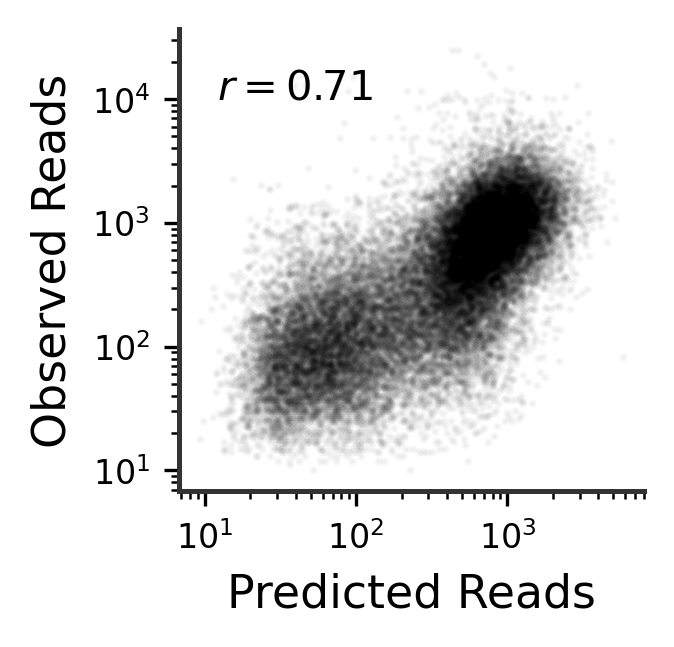

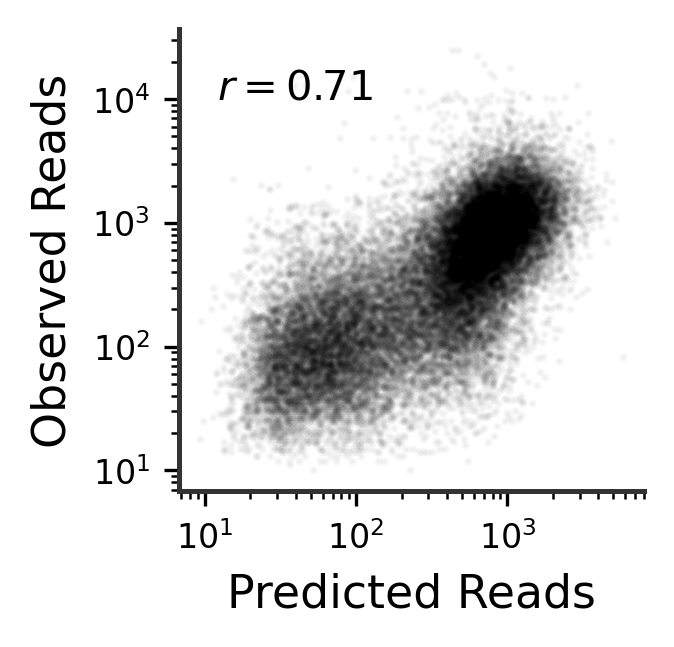

In [7]:
def plot_pred_vs_true_counts(pred_logcounts, true_counts, save_path = None):
    
    plt.figure(figsize=(2, 2), dpi=300)
    
    # if the model preds/data are stranded, merge the two strands
    if len(pred_logcounts.shape) > 1:
        pred_logcounts = np.sum(pred_logcounts, axis=-1)
    if len(true_counts.shape) > 1:
        true_counts = np.sum(true_counts, axis=-1)
    assert pred_logcounts.shape == true_counts.shape

    plt.scatter(np.exp(pred_logcounts), true_counts,
                alpha = 0.03, s = 1, color="k")

    plt.semilogx()
    plt.semilogy()

    plt.ylabel("Observed Reads", fontsize=11)
    plt.xlabel("Predicted Reads", fontsize=11)
    
    pearson_r = np.corrcoef(pred_logcounts,
                            np.log1p(true_counts))[0,1]
    plt.text(12, 10000, r'$r = %0.2f$' % pearson_r, fontsize=10)

    # aesthetics
    ax = plt.gca()
    ax.spines[["left", "bottom"]].set_linewidth(1.2)
    ax.spines[["left", "bottom"]].set_color("#333333")
    ax.spines[["top", "right"]].set_visible(False)
    ax.tick_params("both", labelsize=8)
        
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
    

plot_pred_vs_true_counts(pred_logcounts, true_counts)
plot_pred_vs_true_counts(pred_logcounts, true_counts, save_path = figures_dir + "1C_pred_v_true_scatter.png")

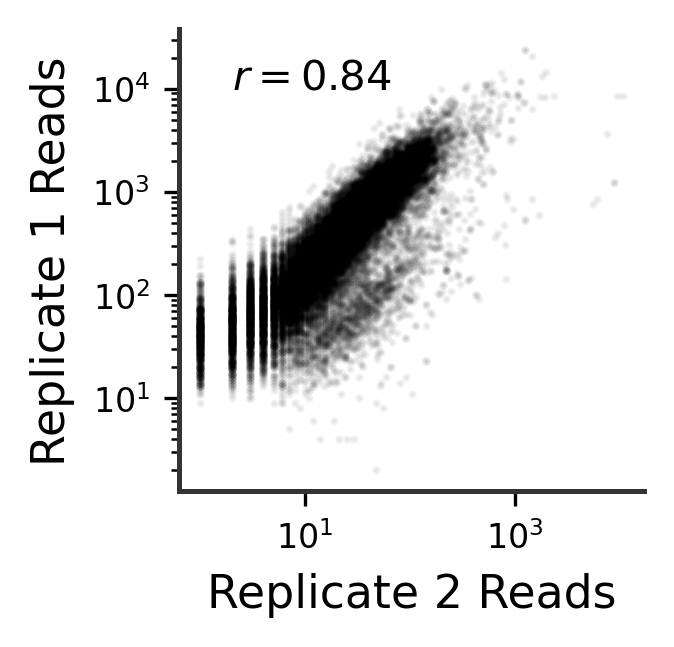

In [8]:
def plot_rep1_vs_rep2_counts(rep1_counts, rep2_counts):
    
    plt.figure(figsize=(2, 2), dpi=300)
    
    # if the model preds/data are stranded, merge the two strands
    if len(rep1_counts.shape) > 1:
        rep1_counts = np.sum(rep1_counts, axis=-1)
    if len(rep2_counts.shape) > 1:
        rep2_counts = np.sum(rep2_counts, axis=-1)
    assert rep1_counts.shape == rep2_counts.shape

    plt.scatter(rep1_counts, rep2_counts,
                alpha = 0.05, s = 1, color="k")

    plt.semilogx()
    plt.semilogy()

    plt.ylabel("Replicate 1 Reads", fontsize=11)
    plt.xlabel("Replicate 2 Reads", fontsize=11)
    
    pearson_r = np.corrcoef(np.log1p(rep1_counts),
                            np.log1p(rep2_counts))[0,1]
    plt.text(2, 10000, r'$r = %0.2f$' % pearson_r, fontsize=10)

    # aesthetics
    ax = plt.gca()
    ax.spines[["left", "bottom"]].set_linewidth(1.2)
    ax.spines[["left", "bottom"]].set_color("#333333")
    ax.spines[["top", "right"]].set_visible(False)
    ax.tick_params("both", labelsize=8)
        
    plt.show()
    

plot_rep1_vs_rep2_counts(r1_profs.sum(axis=(-1,-2)),
                         r2_profs.sum(axis=(-1,-2)))

In [34]:
def get_replicate_val_metrics(rep1_profs, rep2_profs):
    # need to make one of the replicates look like model predictions
    # (normalize to sum to 1, then take the log)
    # (need to add pseudocount to avoid log of 0 error)
    log_rep2_profs = np.log((rep2_profs + 1e-2) / (rep2_profs + 1e-2).sum(axis=(-1,-2), keepdims=True))

    metrics = compute_performance_metrics(rep1_profs.swapaxes(1,2)[:, None, :, :],
                                          log_rep2_profs.swapaxes(1,2)[:, None, :, :],
                                          rep1_profs.sum(axis=-1)[:, None, :],
                                          np.log1p(rep2_profs.sum(axis=-1))[:, None, :],
                                          smooth_true_profs=False,
                                          smooth_pred_profs=False)
    metrics["jsd"] = np.sqrt(metrics["jsd"])
    
    return metrics

rep_val_metrics = get_replicate_val_metrics(pr1_profs, pr2_profs)

In [32]:
def get_nonsmooth_val_metrics(true_profs, log_pred_profs,
                              true_counts, pred_logcounts):
        
    metrics = compute_performance_metrics(true_profs.swapaxes(1,2)[:, None, :, :],
                                          log_pred_profs.swapaxes(1,2)[:, None, :, :],
                                          true_counts[:, None, :],
                                          np.concatenate((pred_logcounts[:, None, None],
                                                          pred_logcounts[:, None, None]), axis=-1),
                                          smooth_true_profs=False,
                                          smooth_pred_profs=False)
    metrics["jsd"] = np.sqrt(metrics["jsd"])
    return metrics

val_metrics = get_nonsmooth_val_metrics(true_profs, log_pred_profs,
                                        true_counts, pred_logcounts)

In [33]:
def get_avg_baseline_val_metrics(true_profs, true_counts, avg_profiles_over_folds):
    denom = np.sum(avg_profiles_over_folds, axis=(-1,-2), keepdims=True)
    log_avg_prof = np.log(avg_profiles_over_folds / denom)
    
    rand_pred_logcounts = np.ones_like(true_counts)

    metrics = compute_performance_metrics(true_profs.swapaxes(1,2)[:, None, :, :],
                                          log_avg_prof.swapaxes(1,2)[:, None, :, :],
                                          true_counts[:, None, :],
                                          rand_pred_logcounts[:, None, :],
                                          smooth_true_profs=False,
                                          smooth_pred_profs=False)
    metrics["jsd"] = np.sqrt(metrics["jsd"])
    
    return metrics


avgprof_val_metrics = get_avg_baseline_val_metrics(true_profs, true_counts, avg_profiles_over_folds)

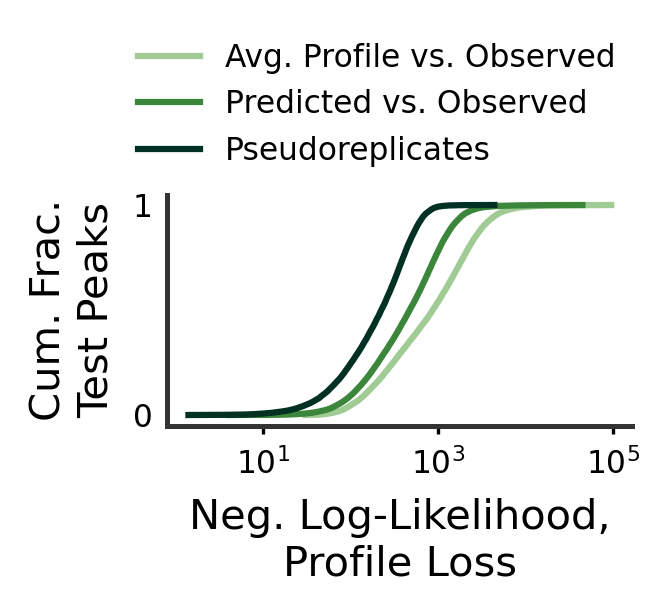

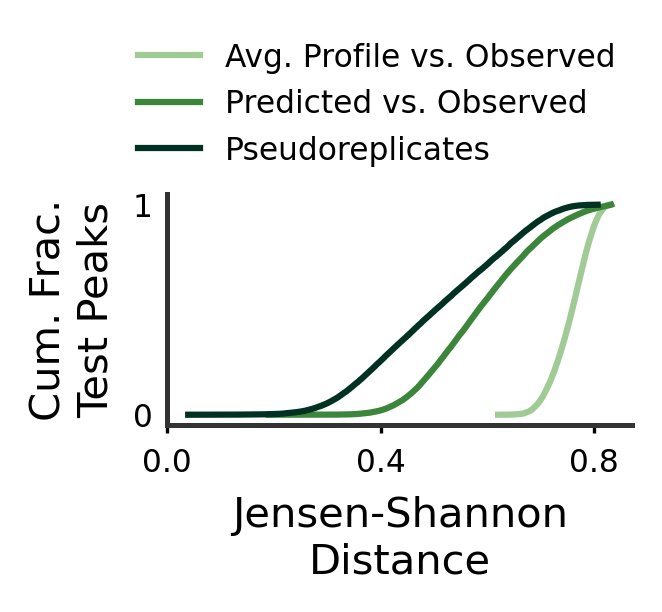

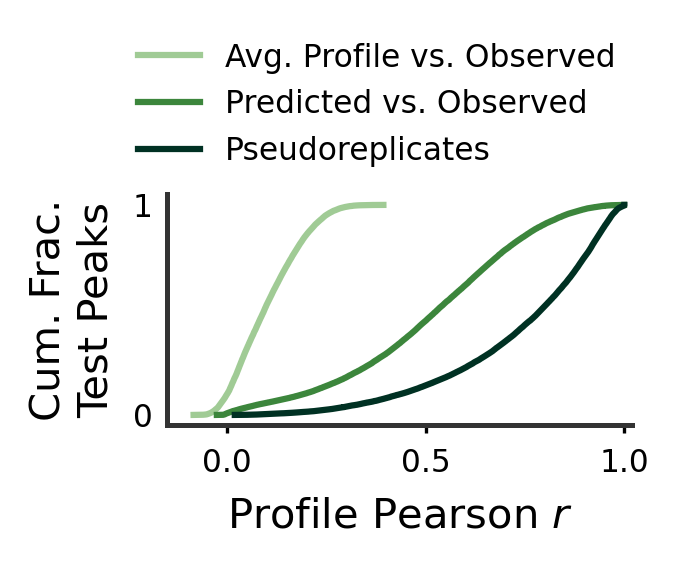

In [135]:
metric_names_fancy = {"nll" : "Neg. Log-Likelihood,\nProfile Loss",
                      "jsd" : "Jensen-Shannon\nDistance",
                      "profile_pearson" : "Profile Pearson " + r'$r$'}


def plot_prof_performance_cdf(val_metrics, rep_val_metrics, avgprof_val_metrics,
                              metric = "nll", save_path = None):

    fig = plt.figure(figsize=(2,1), dpi=300)
    
    ax = plt.gca()
    pred_vs_obs = val_metrics[metric].squeeze()
    rep_baseline = rep_val_metrics[metric].squeeze()
    avg_baseline = avgprof_val_metrics[metric].squeeze()
    
    pred_vs_obs = np.sort(pred_vs_obs)
    rep_baseline = np.sort(rep_baseline)
    avg_baseline = np.sort(avg_baseline)
    cdf = np.array(range(len(pred_vs_obs)))/float(len(pred_vs_obs))

    ax.plot(avg_baseline, cdf, color="#A0CB95", alpha=1, label="Avg. Profile vs. Observed")
    ax.plot(pred_vs_obs, cdf, color="#3C863C", alpha=1, label="Predicted vs. Observed")
    ax.plot(rep_baseline, cdf, color="#003123", alpha=1, label="Pseudoreplicates")

    if metric in ["nll"]:
        plt.semilogx()
    if metric in ["jsd"]:
        ax.set_xlim(-0, ax.get_xlim()[1])
        ax.set_xticks([0, 0.4, 0.8], fontsize=6)
    if metric in ["profile_pearson"]:
        ax.set_xlim(-0.15, 1.02)

    ax.set_xlabel(metric_names_fancy[metric], fontsize = 10)
    ax.legend(fontsize=7.5, frameon=False, bbox_to_anchor=(0.45,1.78), loc="upper center")

    ax.set_yticks([0, 1], fontsize=6)
    ax.set_ylabel("Cum. Frac.\nTest Peaks", fontsize = 10)

    # aesthetics
    ax.spines[["left", "bottom"]].set_linewidth(1.2)
    ax.spines[["left", "bottom"]].set_color("#333333")
    ax.spines[["top", "right"]].set_visible(False)
    
    ax.yaxis.set_ticks_position('none')
    ax.tick_params("y", length=0, labelsize=7.5)
    ax.tick_params("x", length=2, labelsize=7.5)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()


for metric_name in ["nll", "jsd", "profile_pearson"]:
    plot_prof_performance_cdf(val_metrics, rep_val_metrics,
                              avgprof_val_metrics,
                              metric_name, save_path = figures_dir + "1D_" + metric_name + ".png")

In [41]:
def get_norm_val_metrics(val_metrics, rep_val_metrics, rand_val_metrics,
                                   metrics = metric_names_fancy.keys()):
    
    norm_val_metrics = dict()

    for metric in metrics:
        pred_vs_obs = val_metrics[metric]
        rep_baseline = rep_val_metrics[metric]
        rand_baseline = rand_val_metrics[metric]

        # changed 1/24/24 so bigger is worse for JSD
        norm_metrics = 1 - (pred_vs_obs - rand_baseline) / (rep_baseline - rand_baseline)
        norm_metrics = np.clip(norm_metrics, 0, 1)
        norm_val_metrics[metric] = norm_metrics

    return norm_val_metrics

norm_val_metrics = get_norm_val_metrics(val_metrics, rep_val_metrics, avgprof_val_metrics)

In [42]:
def look_at_prof_metrics_over_folds(metrics, fold_labels, metric_name="jsd"):
    metrics_over_folds = []
    for fold in sorted(list(set(fold_labels))):
        in_fold = np.array([fold_label == fold for fold_label in fold_labels])
        
        metrics_fold = metrics[metric_name][in_fold]
        
        metrics_over_folds.append(np.median(metrics_fold))
        
    print("Genome-wide Test JSDs:")
    print(np.median(metrics[metric_name]))
    print("Average Within-Fold Test JSD:")
    print(np.mean(metrics_over_folds))
    print("Standard Deviation of JSD Across Folds:")
    print(np.std(metrics_over_folds))
    
look_at_prof_metrics_over_folds(val_metrics, fold_labels)

Genome-wide Test JSDs:
0.5835994485249074
Average Within-Fold Test JSD:
0.583447913063229
Standard Deviation of JSD Across Folds:
0.0036979509261809615


In [43]:
# to report upper and lower bound stuff across folds
look_at_prof_metrics_over_folds(rep_val_metrics, fold_labels)
look_at_prof_metrics_over_folds(avgprof_val_metrics, fold_labels)

Genome-wide Test JSDs:
0.503001309766065
Average Within-Fold Test JSD:
0.5028306481216613
Standard Deviation of JSD Across Folds:
0.00673826348727337
Genome-wide Test JSDs:
0.7594182414229886
Average Within-Fold Test JSD:
0.7594310805646163
Standard Deviation of JSD Across Folds:
0.0012304995600250354


In [44]:
def look_at_norm_prof_metrics_over_folds(metrics, fold_labels, metric_name="jsd"):
    metrics_over_folds = []
    for fold in sorted(list(set(fold_labels))):
        in_fold = np.array([fold_label == fold for fold_label in fold_labels])
        
        metrics_fold = metrics[metric_name][in_fold]
        
        metrics_over_folds.append(np.mean(metrics_fold))
        
    print("Genome-wide Test Norm. JSDs:")
    print(np.mean(metrics[metric_name]))
    print("Average Within-Fold Test Norm. JSD:")
    print(np.mean(metrics_over_folds))
    print("Standard Deviation of Norm. JSD Across Folds:")
    print(np.std(metrics_over_folds))
    
look_at_norm_prof_metrics_over_folds(norm_val_metrics, fold_labels)

Genome-wide Test Norm. JSDs:
0.32596268165709863
Average Within-Fold Test Norm. JSD:
0.32614756031526015
Standard Deviation of Norm. JSD Across Folds:
0.01463445749056917


In [45]:
from common_functions import get_orientation_indexes, get_norm_shannon_entropies

#norm_shannon_entropies = get_norm_shannon_entropies(true_profs, true_counts)

0.43512207137939557


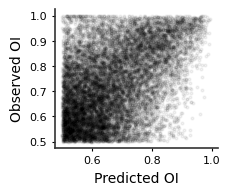

Pearson r, all peaks with AT LEAST 500 reads:
0.733910099576216


/mnt/lab_data2/kcochran/procapnet/src/figure_notebooks/common_functions.py:5: RuntimeWarning: invalid value encountered in true_divide
  return np.max(profiles.sum(axis=-1), axis=-1) / np.sum(profiles, axis=(-1,-2))


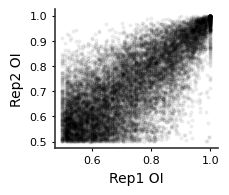

In [46]:
def pred_vs_observed_vs_reps_ois(true_profs, pred_profs, r1_profs, r2_profs):

    true_ois = get_orientation_indexes(true_profs)
    pred_ois = get_orientation_indexes(np.exp(pred_profs))

    atleast100_reads = true_profs.sum(axis=(-1,-2)) >= 500

    print(np.corrcoef(pred_ois[atleast100_reads],
                true_ois[atleast100_reads])[0,1])
    
    plt.figure(figsize=(2.1, 1.8))

    plt.scatter(pred_ois[atleast100_reads],
                true_ois[atleast100_reads],
                s = 4, alpha=0.05, color="k")

    plt.xlabel("Predicted OI", fontsize=10)
    plt.ylabel("Observed OI", fontsize=10)
    
    # aesthetics
    ax = plt.gca()
    ax.spines[["left", "bottom"]].set_linewidth(1.2)
    ax.spines[["left", "bottom"]].set_color("#333333")
    ax.spines[["top", "right"]].set_visible(False)
    ax.tick_params(length=2, labelsize=8)

    plt.show()

    r1_ois = get_orientation_indexes(r1_profs)
    r2_ois = get_orientation_indexes(r2_profs)
    
    print("Pearson r, all peaks with AT LEAST 500 reads:")
    print(np.corrcoef(np.nan_to_num(r1_ois[atleast100_reads]),
                      np.nan_to_num(r2_ois[atleast100_reads]))[0,1])
    
    plt.figure(figsize=(2.1, 1.8))

    plt.scatter(r1_ois[atleast100_reads],
                r2_ois[atleast100_reads],
                s = 4, alpha=0.05, color="k")

    plt.xlabel("Rep1 OI", fontsize=10)
    plt.ylabel("Rep2 OI", fontsize=10)
    
    # aesthetics
    ax = plt.gca()
    ax.spines[["left", "bottom"]].set_linewidth(1.2)
    ax.spines[["left", "bottom"]].set_color("#333333")
    ax.spines[["top", "right"]].set_visible(False)
    ax.tick_params(length=2, labelsize=8)

    plt.show()
        
pred_vs_observed_vs_reps_ois(true_profs, log_pred_profs, r1_profs, r2_profs)

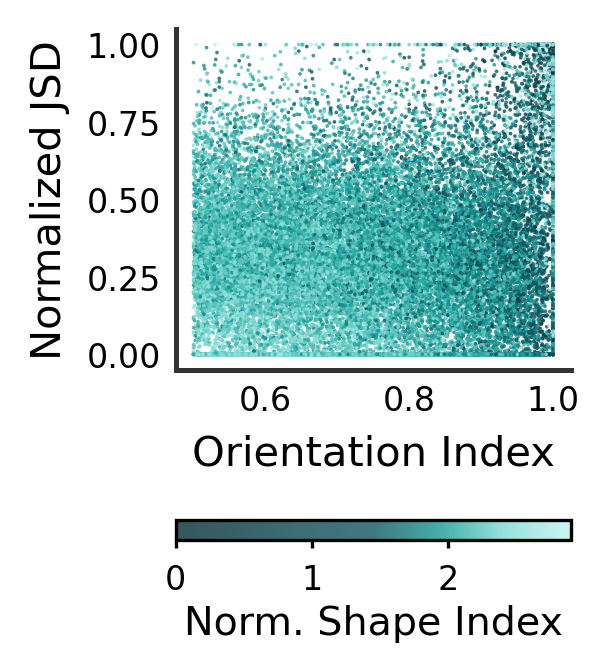

In [49]:
norm_metric_names_fancy = {"nll" : "Norm. Profile Loss",
                           "jsd" : "Normalized JSD",
                           "profile_pearson" : "Norm. Profile\nPearson " + r'$r$'}

def metrics_by_oi_and_nsi(val_metrics, true_profs, true_counts, metric = "nll", save_path = None):

    metric_vals = val_metrics[metric]

    plt.figure(figsize=(1.7, 2.5), dpi=300)

    colors = ["#032D34", "#073A42", "#0D4B55", "#105661", "#149A94", "#7FDBD4", "#C1F3ED"]
    color = ["#03252B", "#073A42", "#105661", "#149A94", "#3CABA7", "#5EBAB6"]
    cmap = get_continuous_cmap(colors)
    
    plt.scatter(get_orientation_indexes(true_profs),
                metric_vals,
                c = get_norm_shannon_entropies(true_profs, true_counts),
                s = 0.8, alpha=0.8, cmap=cmap, linewidths=0)

    ax = plt.gca()
    ax.spines[["left", "bottom"]].set_linewidth(1.2)
    ax.spines[["left", "bottom"]].set_color("#333333")
    ax.spines[["top", "right"]].set_visible(False)
    ax.tick_params(length=0, labelsize=8)

    plt.xlabel("Orientation Index", fontsize=10)
    plt.ylabel(norm_metric_names_fancy[metric], fontsize=10)

    cb = plt.colorbar(pad=0.26, orientation="horizontal")
    cb.ax.tick_params(labelsize=8, length=2)
    cb.set_label(label="Norm. Shape Index", fontsize=9.5, labelpad=2)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
        

#for metric_name in ["nll", "jsd", "profile_pearson"]:
for metric_name in ["jsd"]:
    metrics_by_oi_and_nsi(norm_val_metrics, true_profs, true_counts, metric_name,
                         save_path = figures_dir + "S1_OI_by_NSI_by_" + metric_name + ".png")

In [50]:
from load_annotations_utils import load_coords_with_summits

def load_coords(cell_type, model_type, data_type):
    config = MergedFilesConfig(cell_type, model_type, data_type)
    return load_coords_with_summits(config.all_peak_path,
                                    in_window)

coords = load_coords(cell_type, model_type, data_type)

In [51]:
from load_annotations_utils import find_peak_overlap_labels, get_ccre_bed

def load_ccre_annots(cell_type, coords):
    return find_peak_overlap_labels(coords, get_ccre_bed(cell_type, proj_dir),
                                    in_window, out_window) 

ccre_annots = load_ccre_annots(cell_type, coords)

In [52]:
ccre_annots["PLS_no_pELS"] = ccre_annots["PLS"] * (~ ccre_annots["pELS"])
ccre_annots["PLS_with_pELS"] = ccre_annots["PLS"] * ccre_annots["pELS"]

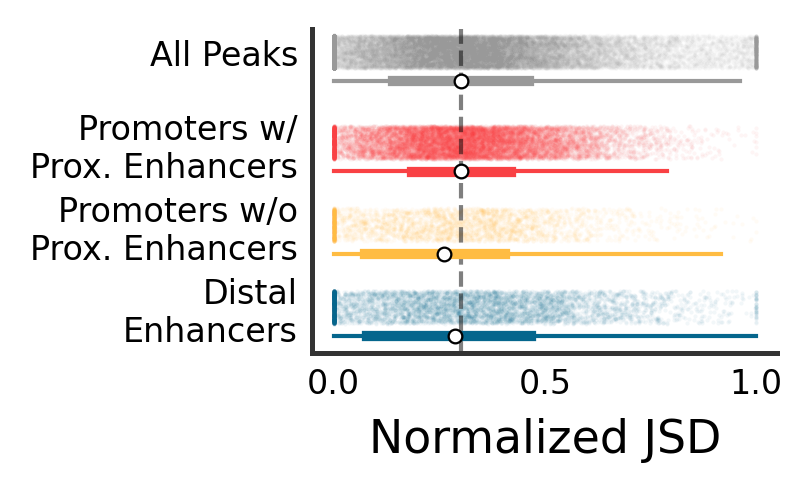

In [66]:
from plot_utils import jitter_dots, plot_scatter_and_boxplot
    

def plot_stratify_but_subset(val_metrics, ccre_annots, metric = "nll", save_path = None):
    metric_names = {"nll" : "Norm. Profile Loss",
                    "jsd" : "Normalized JSD",
                    "profile_pearson" : "Normalized Profile\n" + r'Pearson $r$'}
    
    annots_to_colors = {"PLS" : "#f94144",
                        "pELS" : "#ffbc42",
                        "dELS" : "#05668d",
                        "PLS_with_pELS" : "#f94144",
                        "PLS_no_pELS" : "#ffbc42"}

    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal\nEnhancers",
                        "dELS" : "Distal\nEnhancers",
                        "PLS_with_pELS" : "Promoters w/\nProx. Enhancers",
                        "PLS_no_pELS" : "Promoters w/o\nProx. Enhancers"}

    annots_to_plot = ["PLS_with_pELS", "PLS_no_pELS", "dELS"]

    metrics = val_metrics[metric].squeeze()
    
    
    
    plt.figure(figsize=(2, 1.4), dpi=300)

    plt.axvline(np.median(metrics), linestyle="dashed", alpha=0.5, color="k", linewidth=1)
    
    num_groups = 2
    groupings = [0] + [1]*len(annots_to_labels)
    assert max(groupings) == num_groups - 1, (num_groups, groupings)
    
    y_index = 0
    
    plot_scatter_and_boxplot(metrics, y_index, color="#999999", dot_alpha=0.03)
    y_index += 1
    y_labels = ["All Peaks"]
    yticks = [0]
    y_offset = 0.1
    
    for annot_name in annots_to_plot:
        y_labels.append(annots_to_labels[annot_name])
        yticks.append(y_index + y_offset)
        metrics_subset = metrics[ccre_annots[annot_name]]
        plot_scatter_and_boxplot(metrics_subset, y_index + y_offset,
                                 color = annots_to_colors[annot_name],
                                 dot_alpha = 0.05)
        y_index += 1

    plt.xlabel(metric_names[metric], fontsize=11)
        
    # aesthetics
    ax = plt.gca()
    ax.spines[["left", "bottom"]].set_linewidth(1.2)
    ax.spines[["left", "bottom"]].set_color("#333333")
    ax.spines[["top", "right"]].set_visible(False)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    ax.tick_params(length=0)
    plt.xticks(fontsize=8)

    plt.yticks(yticks, y_labels, fontsize = 8)
    
    plt.ylim(plt.gca().get_ylim()[1], plt.gca().get_ylim()[0] - 0.1)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
    
#for metric_name in ["nll", "jsd", "profile_pearson"]:
for metric_name in ["jsd"]:
    plot_stratify_but_subset(norm_val_metrics, ccre_annots, metric=metric_name,
                            save_path = figures_dir + "1E_stratify_cCREs_" + metric_name + ".png")

## Individual Examples

In [67]:
from file_configs import MergedFilesConfig

def load_scores(cell_type, model_type, data_type):
    config = MergedFilesConfig(cell_type, model_type, data_type)
        
    prof_scores = np.load(config.profile_onehot_scores_path)
    counts_scores = np.load(config.counts_onehot_scores_path)
    return prof_scores, counts_scores

prof_scores, counts_scores = load_scores(cell_type, model_type, data_type)

In [68]:
def overlap(coord1, coord2):
    # chromosome should be the same
    if coord1[0] != coord2[0]:
        return False
    if coord2[2] < coord1[1]:
        return False
    if coord2[1] > coord1[2]:
        return False
    return True

def get_locus_index(coords, chrom, start, end):
    assert type(chrom) == str, chrom
    assert type(start) == int, start
    assert type(end) == int, end
    coord_to_find = (chrom, start, end)
    
    match_indexes = []
    matches = []
    for index, coord in enumerate(coords):
        if overlap(coord, coord_to_find):
            matches.append(coord)
            match_indexes.append(index)
            
    if len(matches) == 0:
        print("Coordinate not found :(")
        return None
    elif len(matches) > 1:
        print(str(len(matches)) + " matches to coordinate found: ", coord_to_find)
    else:
        print(coord_to_find, "--->", matches[0])
        return match_indexes[0], matches[0]
        
    mid_for_coord_to_find = (start + end) // 2
    dists_for_matches = [abs(((c[1] + c[2]) // 2) - mid_for_coord_to_find) for c in matches]
    closest_match_index = match_indexes[np.argmin(dists_for_matches)]
    closest_match = matches[np.argmin(dists_for_matches)]
    
    print(coord_to_find, "--->", closest_match)
    
    return closest_match_index, closest_match
        

tal1_altpromoter_index, _ = get_locus_index(coords, "chr1", 47231230, 47231655)
gata1_enhancer_index, _ = get_locus_index(coords, "chrX", 48789633, 48789866)
hbe1_promoter_index, hbe1_promoter_coords = get_locus_index(coords, "chr11", 5269828, 5270185)
hbe1_enhancer_index, hbe1_enhancer_coords = get_locus_index(coords, "chr11", 5288180, 5288433)
pola1_promoter_index, pola1_promoter_coords = get_locus_index(coords, "chrX", 24693718, 24693987)
pola1_enhancer_index, pola1_enhancer_coords = get_locus_index(coords, "chrX", 24297329, 24297563)

2 matches to coordinate found:  ('chr1', 47231230, 47231655)
('chr1', 47231230, 47231655) ---> ('chr1', 47230428, 47232542, 47231419, 47231261)
('chrX', 48789633, 48789866) ---> ('chrX', 48788692, 48790806, 48789865, 48789664)
('chr11', 5269828, 5270185) ---> ('chr11', 5268953, 5271067, 5270098, 5269942)
('chr11', 5288180, 5288433) ---> ('chr11', 5287265, 5289379, 5288334, 5288250)
('chrX', 24693718, 24693987) ---> ('chrX', 24692804, 24694918, 24693920, 24693752)
('chrX', 24297329, 24297563) ---> ('chrX', 24296353, 24298467, None, 24297416)


findfont: Font family ['Arial Rounded'] not found. Falling back to DejaVu Sans.


0.8859420963726259


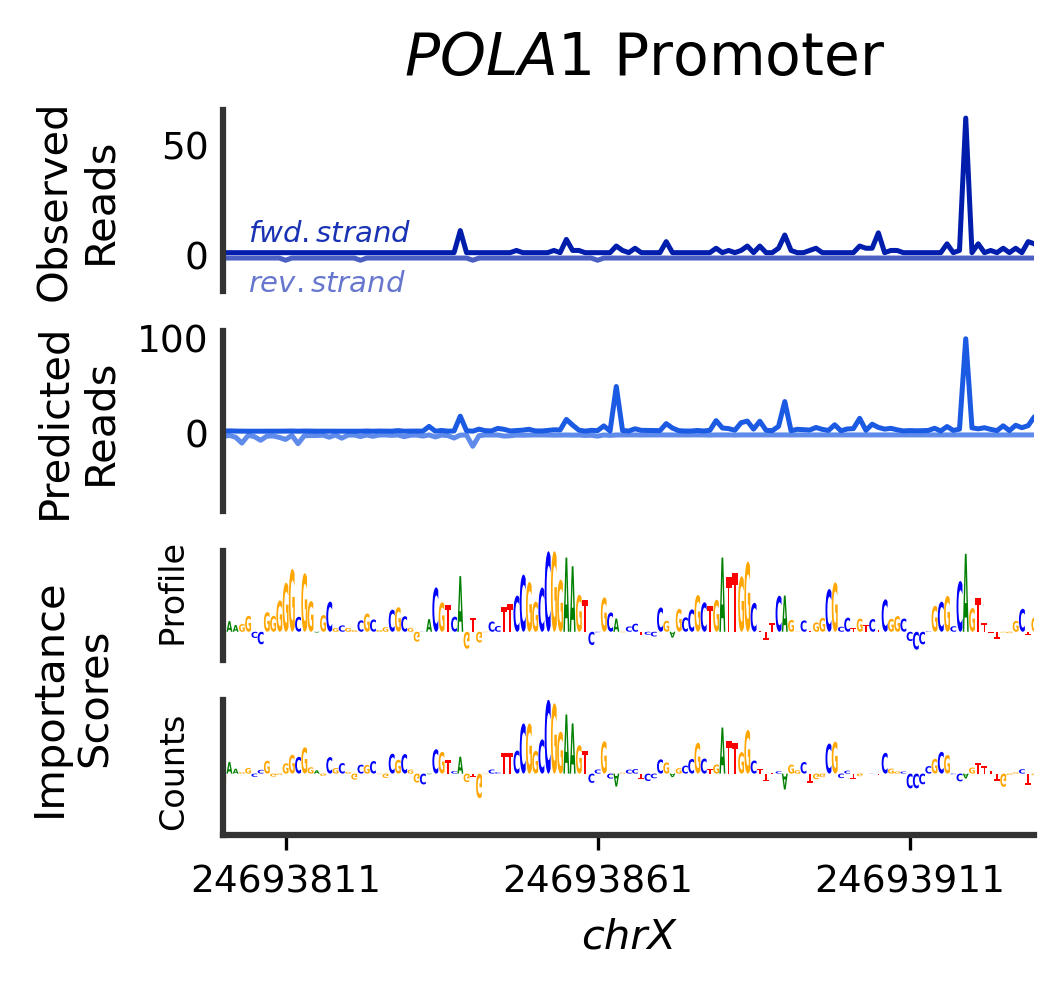

In [83]:
from matplotlib.offsetbox import AnchoredText
import logomaker

def plot_motif_on_ax_modified(array, ax, fix_appearance = True):
    assert len(array.shape) == 2 and array.shape[-1] == 4, array.shape
    # reformat pwm to what logomaker expects
    df = pd.DataFrame(array, columns=['A', 'C', 'G', 'T'])
    df.index.name = 'pos'

    # plot motif ("baseline_width=0" removes the y=0 line)
    logo = logomaker.Logo(df, ax=ax, font_name='Arial Rounded', baseline_width=0)
    
    ax.set_ylim(min(df.sum(axis=1).min(), 0), df.sum(axis=1).max())
    
    if fix_appearance:
        # fix appearance to be less terrible
        logo.style_spines(visible=False)
        ax.set_xticks([])
        ax.set_yticks([])
    
    return logo


def plot_example(true_profile, pred_profile, prof_scores, counts_scores,
                 locus_coords, zoom_mid = None, zoom_width = None, in_window = in_window,
                 prof_len = out_window, title = None, linewidth=None, label_strands = True,
                 imp_score_pad = 0.185, save_path = None):
    
    num_subplots = 4
    
    fig, axes = plt.subplots(num_subplots, figsize=(3, 2.7),
                             sharex=True, dpi=300,
                             gridspec_kw = {"height_ratios" : [1,1,0.6,0.75]})
    plt.tight_layout(pad=0)
    
    if title is not None:
        fig.suptitle(title, x=0.53, y = 1.08, fontsize=14, horizontalalignment='center')
    
    axis_fontsize = 10
    prof_linewidth = 1.2
    if linewidth is not None:
        prof_linewidth *= linewidth
    
    x_range = np.arange(0,prof_len)
    offset = np.max(np.abs(true_profile)) * 0.02
    axes[0].plot(x_range, true_profile[0] + offset,
                 alpha=1, c = "#001DAC", linewidth=prof_linewidth)
    axes[0].plot(x_range, -1 * true_profile[1] - offset,
                 alpha=0.7, c = "#001DAC", linewidth=prof_linewidth)
    axes[0].set_ylabel("Observed\nReads",
                       fontsize = axis_fontsize)
    
    offset = np.max(np.abs(pred_profile)) * 0.02
    axes[1].plot(x_range, pred_profile[0] + offset,
                 alpha=1, c = "#1B5AE3", linewidth=prof_linewidth)
    axes[1].plot(x_range, -1 * pred_profile[1] - offset,
                 alpha=0.7, c = "#1B5AE3", linewidth=prof_linewidth)
    axes[1].set_ylabel("Predicted\nReads",
                       fontsize = axis_fontsize)
    
    print(np.corrcoef(true_profile[:, zoom_mid - zoom_width : zoom_mid + zoom_width].flatten(),
            pred_profile[:, zoom_mid - zoom_width : zoom_mid + zoom_width].flatten())[0,1])

    
    prof_scores = prof_scores[:, (in_window - out_window) // 2 : in_window - (in_window - out_window) // 2]
    counts_scores = counts_scores[:, (in_window - out_window) // 2 : in_window - (in_window - out_window) // 2]
    
    logo = plot_motif_on_ax_modified(prof_scores.T, axes[2], fix_appearance = False)
    logo = plot_motif_on_ax_modified(counts_scores.T, axes[3], fix_appearance = False)
    
    axes[2].set_ylabel("  Profile", fontsize = axis_fontsize - 2)
    axes[3].set_ylabel("Counts ", fontsize = axis_fontsize - 2)
    
    axes[2].annotate("Importance\nScores",
            xy=(0, 0), xycoords='axes fraction',
            xytext=(-imp_score_pad, -0.35), textcoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',
            fontsize=axis_fontsize, rotation=90)
    
    
    # zoom into correct position, set x-axis tick values to actual coordinates
    
    if zoom_mid is not None and zoom_width is not None:
        zoom_lims = (zoom_mid - zoom_width, zoom_mid + zoom_width)
        plt.xlim(zoom_lims)
        
        # this should be 2114
        locus_coords_width = locus_coords[2] - locus_coords[1]
        # a 0 on this plot's axis corresponds to position [xticks_offset] on this chromosome
        xticks_offset = locus_coords[1] + (locus_coords_width - prof_len) // 2
        
        # modify the xticks to reflect actual genomic coordinates
        og_xticks = axes[-1].get_xticks()[1:-1:2]
        xticks = [int(xt + xticks_offset) for xt in og_xticks]
        plt.xticks(og_xticks, xticks)
        
        axes[-1].set_xlabel(locus_coords[0], style="italic")
    else:
        x_axis_buffer = 10
        plt.xlim(- x_axis_buffer, prof_len + x_axis_buffer)
        
        axes[-1].set_xlabel("Genomic Axis", fontsize = axis_fontsize)
    
    
    # aesthetics
    
    for ax in axes:
        for side in ["top", "right"]:
            ax.spines[side].set_visible(False)
            
        ax.spines["left"].set_linewidth(1.5)
        ax.spines["left"].set_color("#333333")
        
    
    # y-axis: profiles yes, scores no
    
    for ax in axes[:2]:
        ax.tick_params("y", length=0, labelsize=9)
        ax.set_yticks(ax.get_yticks(minor=False)[1:-1],
                      np.abs(ax.get_yticks(minor=False)).astype(int)[1:-1])
        
    for ax in axes[2:]:
        ax.set_yticks([])
        
    # only x-axis line for bottom plot
    
    for ax in axes[:-1]:
        ax.spines["bottom"].set_visible(False)
        ax.tick_params("x", length=0)
            
    axes[-1].spines["bottom"].set_linewidth(1.5)
    axes[-1].spines["bottom"].set_color("#333333")
    axes[-1].tick_params("x", labelsize=9)

    # put more space between scoes and x-axis line
    axes[-1].set_ylim(axes[-1].get_ylim()[0] * 2.5, axes[-1].set_ylim()[1])
    
    if label_strands == True:
        ymin, ymax = axes[0].get_ylim()
        zero_point = - ymin / (ymax - ymin)
        
        axes[0].annotate(r'$fwd. strand$',
            xy=(0.1, 0.1), xycoords='axes fraction',
            xytext=(0.03, zero_point + 0.2), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=7, color="#001DAC", alpha=0.9)
        axes[0].annotate(r'$rev. strand$',
            xy=(0.1, 0.1), xycoords='axes fraction',
            xytext=(0.03, zero_point - 0.08), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=7, color="#001DAC", alpha=0.6)
        
    elif label_strands == "right":
        ymin, ymax = axes[0].get_ylim()
        zero_point = - ymin / (ymax - ymin)
        
        axes[0].annotate(r'$fwd. strand$',
            xy=(0.1, 0.1), xycoords='axes fraction',
            xytext=(1, zero_point + 0.2), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top',
            fontsize=7, color="#001DAC", alpha=0.9)
        axes[0].annotate(r'$rev. strand$',
            xy=(0.1, 0.1), xycoords='axes fraction',
            xytext=(1, zero_point - 0.08), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top',
            fontsize=7, color="#001DAC", alpha=0.6)
    
    
    fig.align_ylabels(axes[:2])
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
    

plot_example(true_profs[pola1_promoter_index],
             np.exp(log_pred_profs[pola1_promoter_index]) * np.exp(pred_logcounts[pola1_promoter_index]),
             prof_scores[pola1_promoter_index],
             counts_scores[pola1_promoter_index],
             pola1_promoter_coords, zoom_mid = 505, zoom_width = 65,
             title=r'$\it{POLA1}$ Promoter', label_strands = True,
             save_path = figures_dir + "1B_pola1_promoter.png")

0.9461167276830837


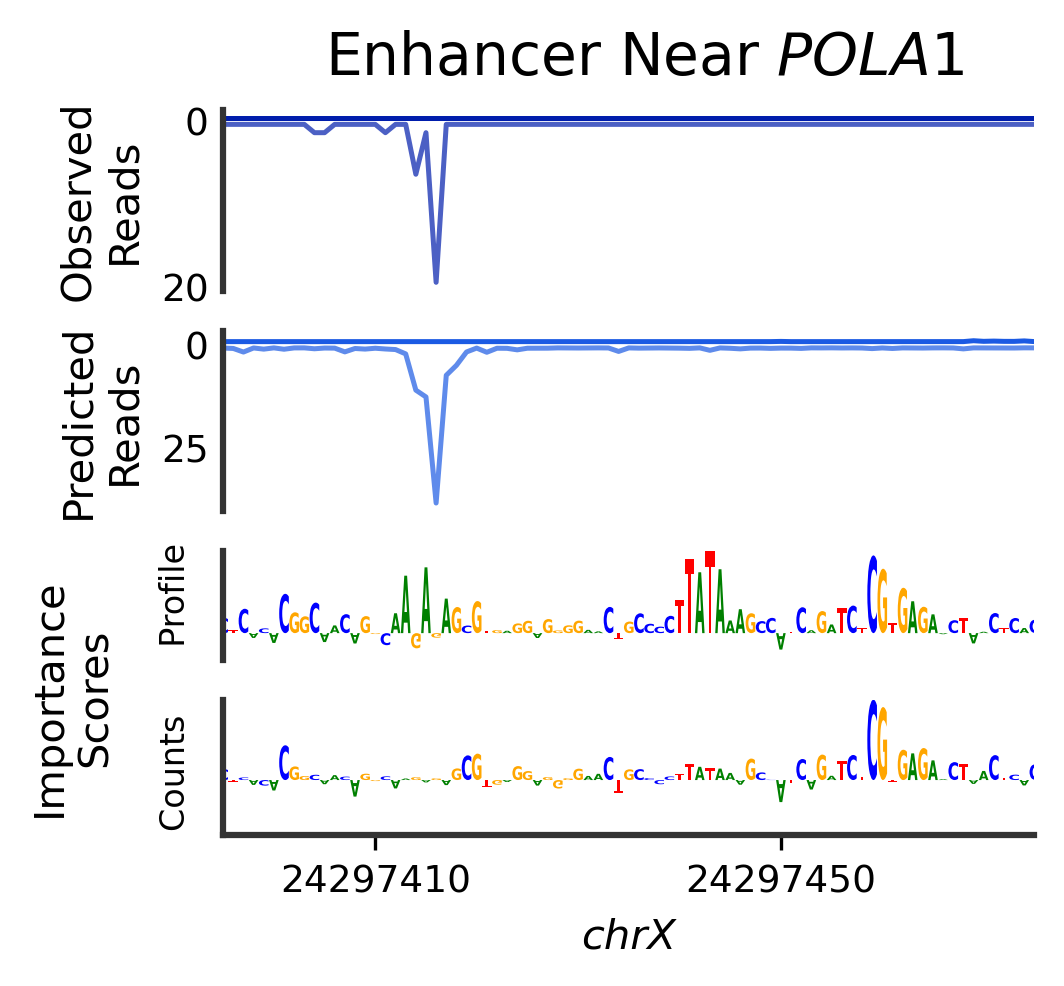

In [85]:
plot_example(true_profs[pola1_enhancer_index],
             np.exp(log_pred_profs[pola1_enhancer_index]) * np.exp(pred_logcounts[pola1_enhancer_index]),
             prof_scores[pola1_enhancer_index],
             counts_scores[pola1_enhancer_index],
             pola1_enhancer_coords, zoom_mid = 525, zoom_width = 40,
             title=r'Enhancer Near $\it{POLA1}$', label_strands = False,
             
            save_path = figures_dir + "1B_pola1_enhancer.png")

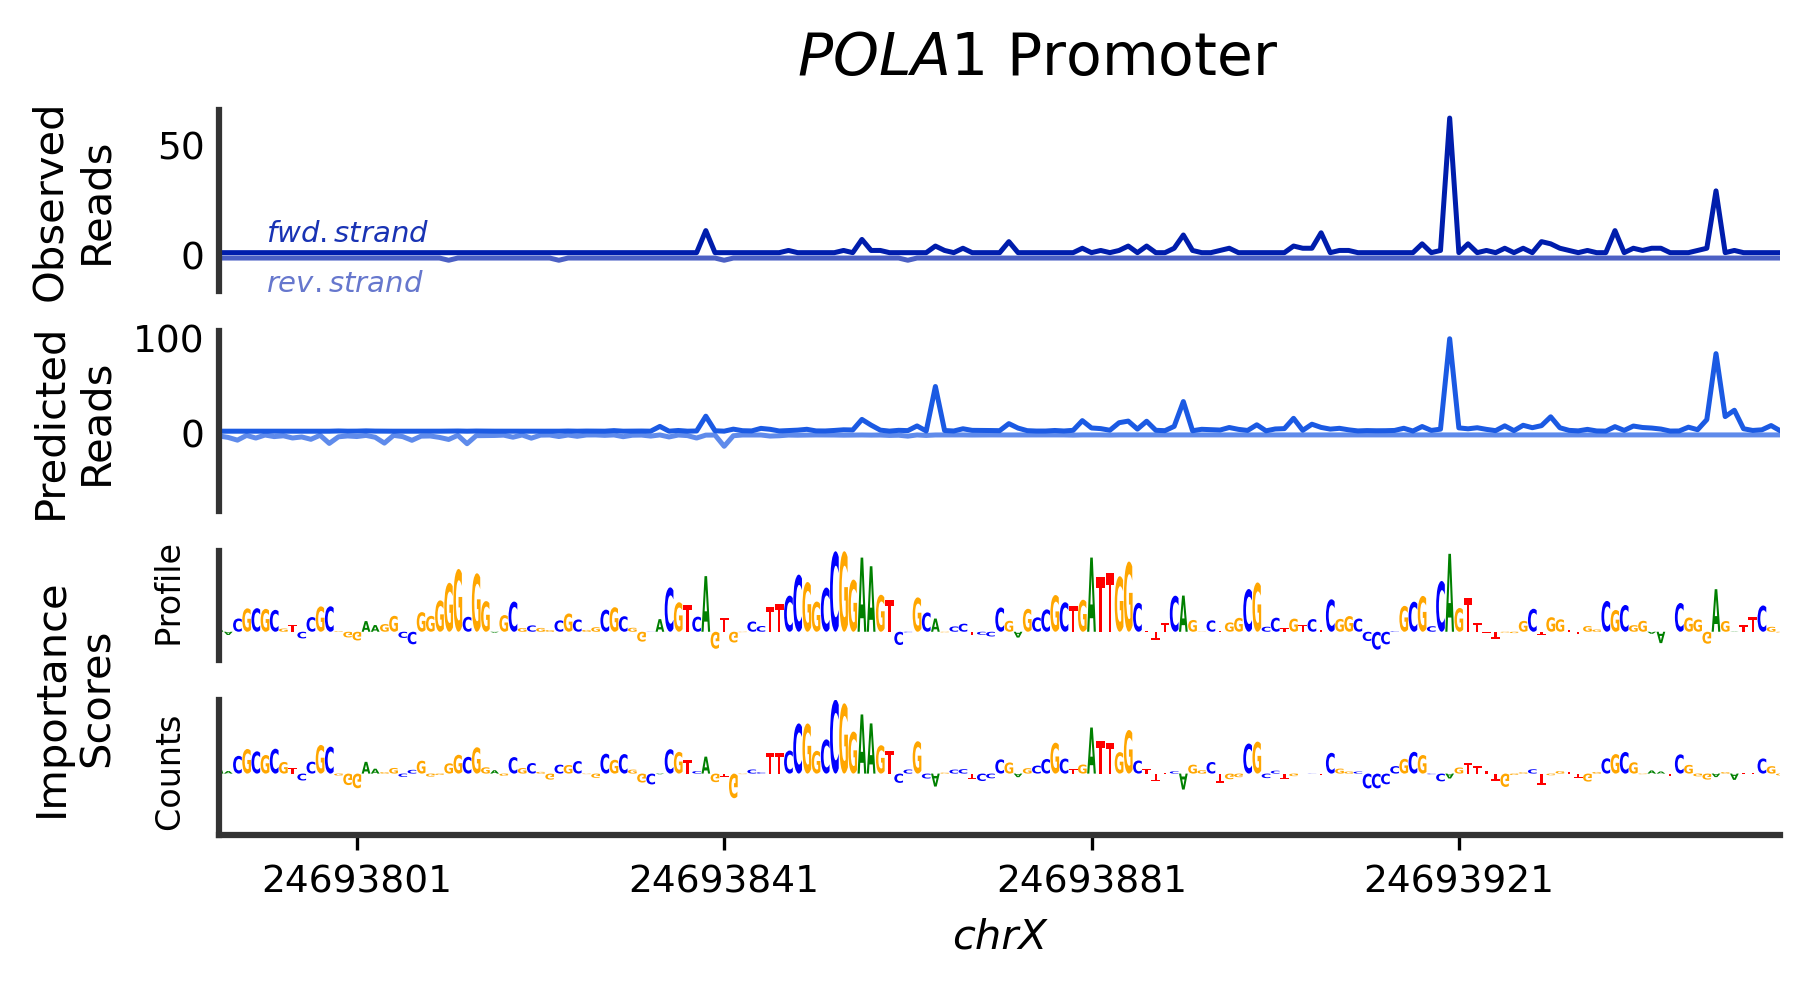

In [86]:
from matplotlib.offsetbox import AnchoredText
import logomaker

def plot_motif_on_ax_modified(array, ax, fix_appearance = True):
    assert len(array.shape) == 2 and array.shape[-1] == 4, array.shape
    # reformat pwm to what logomaker expects
    df = pd.DataFrame(array, columns=['A', 'C', 'G', 'T'])
    df.index.name = 'pos'

    # plot motif ("baseline_width=0" removes the y=0 line)
    logo = logomaker.Logo(df, ax=ax, font_name='Arial Rounded', baseline_width=0)
    
    ax.set_ylim(min(df.sum(axis=1).min(), 0), df.sum(axis=1).max())
    
    if fix_appearance:
        # fix appearance to be less terrible
        logo.style_spines(visible=False)
        ax.set_xticks([])
        ax.set_yticks([])
    
    return logo


def plot_example_wide(true_profile, pred_profile, prof_scores, counts_scores,
                 locus_coords, zoom_mid = None, zoom_width = None, in_window = in_window,
                 prof_len = out_window, title = None, linewidth=None, label_strands = True,
                 imp_score_pad = 0.0925, save_path = None):
    
    num_subplots = 4
    
    fig, axes = plt.subplots(num_subplots, figsize=(5.5, 2.7),
                             sharex=True, dpi=300,
                             gridspec_kw = {"height_ratios" : [1,1,0.6,0.75]})
    plt.tight_layout(pad=0)
    
    if title is not None:
        fig.suptitle(title, x=0.53, y = 1.08, fontsize=14, horizontalalignment='center')
    
    axis_fontsize = 10
    prof_linewidth = 1.2
    if linewidth is not None:
        prof_linewidth *= linewidth
    
    x_range = np.arange(0,prof_len)
    offset = np.max(np.abs(true_profile)) * 0.02
    axes[0].plot(x_range, true_profile[0] + offset,
                 alpha=1, c = "#001DAC", linewidth=prof_linewidth)
    axes[0].plot(x_range, -1 * true_profile[1] - offset,
                 alpha=0.7, c = "#001DAC", linewidth=prof_linewidth)
    axes[0].set_ylabel("Observed\nReads",
                       fontsize = axis_fontsize)
    
    offset = np.max(np.abs(pred_profile)) * 0.02
    axes[1].plot(x_range, pred_profile[0] + offset,
                 alpha=1, c = "#1B5AE3", linewidth=prof_linewidth)
    axes[1].plot(x_range, -1 * pred_profile[1] - offset,
                 alpha=0.7, c = "#1B5AE3", linewidth=prof_linewidth)
    axes[1].set_ylabel("Predicted\nReads",
                       fontsize = axis_fontsize)
    
    #y_max = np.max((true_profile[0], pred_profile[0])) + offset
    #y_min = -1 * (np.max((true_profile[1], pred_profile[1])) + offset)
    
    #axes[0].set_ylim(y_min * 1.05, y_max * 1.05)
    #axes[1].set_ylim(y_min * 1.05, y_max * 1.05)
    
    prof_scores = prof_scores[:, (in_window - out_window) // 2 : in_window - (in_window - out_window) // 2]
    counts_scores = counts_scores[:, (in_window - out_window) // 2 : in_window - (in_window - out_window) // 2]
    
    logo = plot_motif_on_ax_modified(prof_scores.T, axes[2], fix_appearance = False)
    logo = plot_motif_on_ax_modified(counts_scores.T, axes[3], fix_appearance = False)
    
    axes[2].set_ylabel("  Profile", fontsize = axis_fontsize - 2)
    axes[3].set_ylabel("Counts ", fontsize = axis_fontsize - 2)
    
    axes[2].annotate("Importance\nScores",
            xy=(0, 0), xycoords='axes fraction',
            xytext=(-imp_score_pad, -0.35), textcoords='axes fraction',
            horizontalalignment='center', verticalalignment='center',
            fontsize=axis_fontsize, rotation=90)
    
    
    # zoom into correct position, set x-axis tick values to actual coordinates
    
    if zoom_mid is not None and zoom_width is not None:
        zoom_lims = (zoom_mid - zoom_width, zoom_mid + zoom_width)
        plt.xlim(zoom_lims)
        
        # this should be 2114
        locus_coords_width = locus_coords[2] - locus_coords[1]
        # a 0 on this plot's axis corresponds to position [xticks_offset] on this chromosome
        xticks_offset = locus_coords[1] + (locus_coords_width - prof_len) // 2
        
        # modify the xticks to reflect actual genomic coordinates
        og_xticks = axes[-1].get_xticks()[1:-1:2]
        xticks = [int(xt + xticks_offset) for xt in og_xticks]
        plt.xticks(og_xticks, xticks)
        
        axes[-1].set_xlabel(locus_coords[0], style="italic")
    else:
        x_axis_buffer = 10
        plt.xlim(- x_axis_buffer, prof_len + x_axis_buffer)
        
        axes[-1].set_xlabel("Genomic Axis", fontsize = axis_fontsize)
    
    
    # aesthetics
    
    for ax in axes:
        for side in ["top", "right"]:
            ax.spines[side].set_visible(False)
            
        ax.spines["left"].set_linewidth(1.5)
        ax.spines["left"].set_color("#333333")
        
    
    # y-axis: profiles yes, scores no
    
    for ax in axes[:2]:
        ax.tick_params("y", length=0, labelsize=9)
        ax.set_yticks(ax.get_yticks(minor=False)[1:-1],
                      np.abs(ax.get_yticks(minor=False)).astype(int)[1:-1])
        
    for ax in axes[2:]:
        ax.set_yticks([])
        
    # only x-axis line for bottom plot
    
    for ax in axes[:-1]:
        ax.spines["bottom"].set_visible(False)
        ax.tick_params("x", length=0)
            
    axes[-1].spines["bottom"].set_linewidth(1.5)
    axes[-1].spines["bottom"].set_color("#333333")
    axes[-1].tick_params("x", labelsize=9)

    # put more space between scoes and x-axis line
    axes[-1].set_ylim(axes[-1].get_ylim()[0] * 2.5, axes[-1].set_ylim()[1])
    
    if label_strands == True:
        ymin, ymax = axes[0].get_ylim()
        zero_point = - ymin / (ymax - ymin)
        
        axes[0].annotate(r'$fwd. strand$',
            xy=(0.1, 0.1), xycoords='axes fraction',
            xytext=(0.03, zero_point + 0.2), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=7, color="#001DAC", alpha=0.9)
        axes[0].annotate(r'$rev. strand$',
            xy=(0.1, 0.1), xycoords='axes fraction',
            xytext=(0.03, zero_point - 0.08), textcoords='axes fraction',
            horizontalalignment='left', verticalalignment='top',
            fontsize=7, color="#001DAC", alpha=0.6)
        
    elif label_strands == "right":
        ymin, ymax = axes[0].get_ylim()
        zero_point = - ymin / (ymax - ymin)
        
        axes[0].annotate(r'$fwd. strand$',
            xy=(0.1, 0.1), xycoords='axes fraction',
            xytext=(1, zero_point + 0.2), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top',
            fontsize=7, color="#001DAC", alpha=0.9)
        axes[0].annotate(r'$rev. strand$',
            xy=(0.1, 0.1), xycoords='axes fraction',
            xytext=(1, zero_point - 0.08), textcoords='axes fraction',
            horizontalalignment='right', verticalalignment='top',
            fontsize=7, color="#001DAC", alpha=0.6)
    
    
    fig.align_ylabels(axes[:2])
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()
    

plot_example_wide(true_profs[pola1_promoter_index],
             np.exp(log_pred_profs[pola1_promoter_index]) * np.exp(pred_logcounts[pola1_promoter_index]),
             prof_scores[pola1_promoter_index],
             counts_scores[pola1_promoter_index],
             pola1_promoter_coords, zoom_mid = 510, zoom_width = 85,
             title=r'$\it{POLA1}$ Promoter', label_strands = True,
             save_path = figures_dir + "1B_pola1_promoter.png")

## Supplementary Figures

PLS_with_pELS
Pred. vs. Obs. MSE: 0.5910192
Pred vs. Obs Pearson r: 0.47564733178578605
Pred vs. Obs Spearman r: 0.45058833322636

PLS_no_pELS
Pred. vs. Obs. MSE: 1.1794615
Pred vs. Obs Pearson r: 0.4206444921841144
Pred vs. Obs Spearman r: 0.4689887268514059

dELS
Pred. vs. Obs. MSE: 1.0544916
Pred vs. Obs Pearson r: 0.5695905136836257
Pred vs. Obs Spearman r: 0.5291510805486843



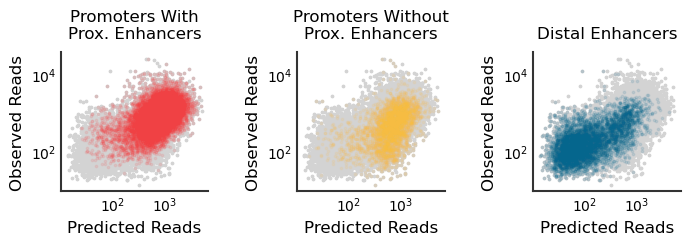

In [89]:
def plot_true_pred_counts_by_annot(true_counts, pred_logcounts, overlap_annots_bools,
                                   save_path = None):
    
    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Distal Enhancers",
                        "PLS_with_pELS" : "Promoters With\nProx. Enhancers",
                        "PLS_no_pELS" : "Promoters Without\nProx. Enhancers" }
    
    annots_to_colors = {"PLS" : "#f94144",
                        "pELS" : "#ffbc42",
                        "dELS" : "#05668d",
                        "PLS_with_pELS" : "#f94144",
                        "PLS_no_pELS" : "#ffbc42"}
    
    fig, axes = plt.subplots(1,3,figsize=(8,1.8))
    
    annots_to_plot = ["PLS_with_pELS", "PLS_no_pELS", "dELS"] #["PLS", "pELS", "dELS"]
    
    all_x = []
    all_y = []
    for annot_name in annots_to_plot:
        all_x.extend(np.exp(pred_logcounts[overlap_annots_bools[annot_name]]).squeeze())
        all_y.extend(true_counts[overlap_annots_bools[annot_name]].squeeze())
    
    for ax, sup_annot_name in zip(axes, annots_to_plot):
        ax.scatter(all_x, all_y, alpha = 1, s = 3,
                    label = "Other", color = "lightgray")
        
        # have to plot last
        true_counts_subset = true_counts[overlap_annots_bools[sup_annot_name]].squeeze()
        pred_logcounts_subset = pred_logcounts[overlap_annots_bools[sup_annot_name]].squeeze()
        
        mse = np.mean((pred_logcounts_subset - np.log1p(true_counts_subset)) ** 2)
        print(sup_annot_name)
        print("Pred. vs. Obs. MSE:", mse)
        print("Pred vs. Obs Pearson r:", np.corrcoef(pred_logcounts_subset, np.log1p(true_counts_subset))[0,1])
        print("Pred vs. Obs Spearman r:", spearmanr(pred_logcounts_subset,
                                                    np.log1p(true_counts_subset)).correlation)
        print("")
        
        ax.scatter(np.exp(pred_logcounts_subset), true_counts_subset, alpha = 0.1, s = 3,
                    label = annots_to_labels[sup_annot_name],
                    color = annots_to_colors[sup_annot_name])

        ax.semilogy()
        ax.semilogx()

        ax.set_xlabel("Predicted Reads", fontsize = 12)
        ax.set_ylabel("Observed Reads", fontsize = 12)

        ax.spines["left"].set_linewidth(1.5)
        ax.spines["bottom"].set_linewidth(1.5)
        ax.spines["left"].set_color("#333333")
        ax.spines["bottom"].set_color("#333333")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.xaxis.set_ticks_position('none') 
        ax.yaxis.set_ticks_position('none')
        ax.tick_params(axis='both', labelsize=10, length=0)
        
        ax.set_title(annots_to_labels[sup_annot_name], fontsize=12, pad=10)

    plt.subplots_adjust(wspace=0.6)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    else:
        plt.show()

    
plot_true_pred_counts_by_annot(true_counts.sum(axis=-1), pred_logcounts, ccre_annots,
                               save_path = figures_dir + "S1_counts_by_ccre.png")

In [90]:
mse = np.mean((pred_logcounts - np.log1p(true_counts.sum(axis=-1))) ** 2)
mse

0.90864563

In [91]:
from motif_hits_utils import load_motif_hits

hits, peak_hits, peak_hit_counts = load_motif_hits(cell_type, model_type, data_type, in_window=in_window)

In [92]:
# This is specific to K562 and the specific profile Modisco run

motif_names = ["BRE/SP", "CA-Inr", "ETS", "NFY", "NRF1", "ATF1", "TATA",
               "THAP11", "YY1", "AP1", "TA-Inr", "CTCF", "ZBTB33", "TCT", "TATATA"]

In [93]:
def get_filter_for_peaks_with_motif(peak_hit_counts, motif_key_labels, motifs_to_find):
    motif_bools = dict()
    for motif in motifs_to_find:
        assert motif in motif_key_labels, (motif, motif_key_labels)
        motif_index = motif_key_labels.index(motif)
        motif_bools[motif] = peak_hit_counts["profile"][:, motif_index] > 0

    return motif_bools

motif_filters = get_filter_for_peaks_with_motif(peak_hit_counts,
                                                motif_names,
                                                ["TATA", "TATATA"]) # used to have CA-Inr, TA-Inr

In [94]:
motif_filters = {"TATA" : np.logical_or(motif_filters["TATA"], motif_filters["TATATA"])}

In [95]:
from load_annotations_utils import find_peak_overlap

housekeeping_genes_bed = proj_dir + "/annotations/hk_promoters_by_transcripts.bed"
hk_annots = find_peak_overlap(coords, housekeeping_genes_bed)

tct_promoters_bed = proj_dir + "/annotations/tct_promoters.bed"
tct_annots = find_peak_overlap(coords, tct_promoters_bed)

In [96]:
from load_annotations_utils import get_gene_region_overlap, load_annotations, does_a_overlap_anything_in_b, clean_coord_summits

gene_regions_files = {"genes" : proj_dir + "/annotations/gene_regions.bed",
                      "TSSs" : proj_dir + "/annotations/TSSs.bed",
                      "promoters" : proj_dir + "/annotations/promoters.bed",
                      "intergenic" : proj_dir + "/annotations/intergenic_regions.bed",
                      "exons" : proj_dir + "/annotations/exons.bed",
                      "introns" : proj_dir + "/annotations/introns.bed",
                      "utrs" : proj_dir + "/annotations/utrs.bed"}


def get_gene_region_overlap(coords, gene_regions_files, in_window=2114, out_window=1000):
    overlaps = dict()
    
    for region_name, region_filepath in gene_regions_files.items():
        regions = load_annotations(region_filepath, label=False)

        # get set of chromosomes included in peak set
        chroms = sorted(list(set(coord[0] for coord in coords)))

        # make dict of chromosome --> sorted list of regions
        regions_by_chrom = {chrom : sorted([c for c in regions if c[0] == chrom]) for chrom in chroms}
        
        overlap_bools = []
        for coord in coords:
            chrom, start, end, summit_pos, summit_neg = clean_coord_summits(coord)
            # adjust the starts and ends of peak coordinates so they only cover summits +1 bp
            coord_adjust = (chrom, min(summit_pos, summit_neg) - 1, max(summit_pos, summit_neg))

            overlap_bool = does_a_overlap_anything_in_b(coord_adjust, regions_by_chrom[chrom])
            overlap_bools.append(overlap_bool)
        
        overlaps[region_name] = np.array(overlap_bools)
        
    return overlaps

gene_region_annots = get_gene_region_overlap(coords, gene_regions_files)

In [97]:
from load_annotations_utils import get_dist_to_TSS

TSS_dists = get_dist_to_TSS(coords, gene_regions_files["TSSs"])

In [98]:
# we will want to label regions as not-promoter anything, only if they aren't also a promoter

gene_region_names = list(gene_region_annots.keys())
for region in gene_region_names:
    if "promoters" in region or "TSSs" in region:
        continue
    if "_not_TSS" in region:  # this is here to avoid bugs if you re-run this cell again
        continue
        
    gene_region_annots[region + "_not_TSS"] = gene_region_annots[region] * (~ gene_region_annots["promoters"])

In [99]:
ccre_annots["PLS"].sum()

16960

In [100]:
(ccre_annots["PLS"] * gene_region_annots["promoters"]).sum()

14519

In [101]:
(gene_region_annots["genes"] * gene_region_annots["intergenic"]).sum()

5040

In [102]:
# 759 out of 863 genic-intergenic peaks are actually annotated as promoters
(gene_region_annots["genes"] * gene_region_annots["intergenic"] * ccre_annots["PLS"]).sum()

4602

In [103]:
# all 759 of those overlap an exon annotation as well, makes sense
(gene_region_annots["genes"] * gene_region_annots["intergenic"] * gene_region_annots["exons"] * ccre_annots["PLS"]).sum()

4602

In [104]:
# most of the 759 overlap a UTR annotation (so are for coding genes)
(gene_region_annots["genes"] * gene_region_annots["intergenic"] * gene_region_annots["utrs"] * ccre_annots["PLS"]).sum()

4098

In [105]:
# most annotated promoters (2035 / 2136) overlap with gene annotations
(gene_region_annots["genes"] * ccre_annots["PLS"]).sum()

15419

In [106]:
# 812 out of 863 genic-intergenic peaks are actually annotated as promoters or "proximal enhancers"
(gene_region_annots["genes"] * gene_region_annots["intergenic"] * np.logical_or(ccre_annots["pELS"], ccre_annots["PLS"])).sum()

4790

In [107]:
[(k, sum(t)) for k, t in gene_region_annots.items()]

[('genes', 24916),
 ('TSSs', 11226),
 ('promoters', 17181),
 ('intergenic', 10658),
 ('exons', 16329),
 ('introns', 13704),
 ('utrs', 11953),
 ('genes_not_TSS', 9148),
 ('intergenic_not_TSS', 4241),
 ('exons_not_TSS', 2397),
 ('introns_not_TSS', 7214),
 ('utrs_not_TSS', 961)]

In [108]:
len(coords), true_counts.sum(axis=-1).shape, ccre_annots["dELS"].shape

(30534, (30534,), (30534,))

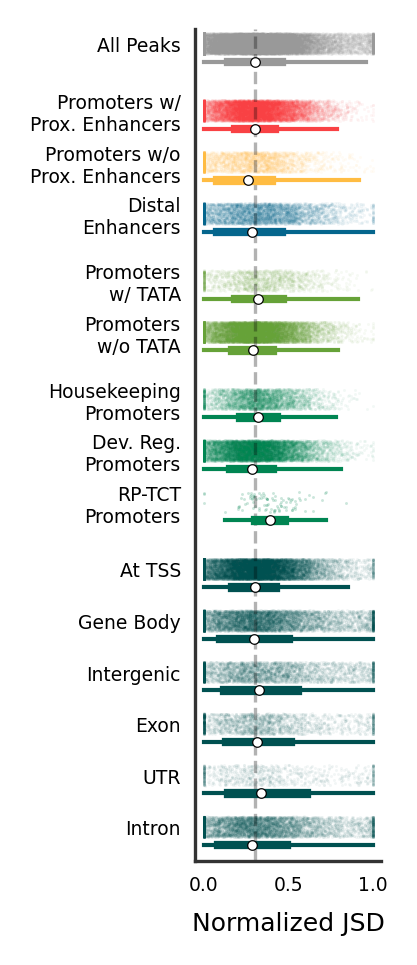

In [142]:
from plot_utils import jitter_dots, plot_scatter_and_boxplot
from matplotlib.cbook import boxplot_stats


def plot_scatter_and_boxplot(data, position, color = "k", dot_size=1, dot_alpha=0.05,
                             box_linewidth=1.5, box_whisker_linewidth=1,
                             white_dot_size=3):
    
    if len(data) < 200:
        dot_alpha = 2 * dot_alpha
    if len(data) < 100:  # double-dipping intended
        dot_alpha = 2 * dot_alpha
        
    dots = plt.scatter(data, [position] * len(data),
                       color = color, s = dot_size, alpha=dot_alpha, linewidths=0)
    jitter_dots(dots, along_y=True, jitter_by=0.2)
    
    bps = boxplot_stats(data)[0]
    
    plt.plot([bps["whislo"], bps["whishi"]], [position + 0.35] * 2,
             linewidth=box_whisker_linewidth, color=color, alpha=1, zorder=30)
    plt.plot([bps["q1"], bps["q3"]], [position + 0.33] * 2,
             linewidth=box_linewidth, color=color, alpha=1, zorder=28)
    plt.plot([bps["q1"], bps["q3"]], [position + 0.38] * 2,
             linewidth=box_linewidth, color=color, alpha=1, zorder=29)

    # draw median dot
    if white_dot_size == 3:
        black_dot_size = 8
    else:
        black_dot_size = white_dot_size * 2.5
    plt.scatter(bps["med"], [position + 0.35], s=black_dot_size, color="k", zorder=31)
    plt.scatter(bps["med"], [position + 0.35], s=white_dot_size, color="white", zorder=32)
    

def plot_stratify(val_metrics, ccre_annots, hk_annots, tct_annots, gene_region_annots,
                  motif_filters, motif_keys_labels, metric = "nll",
                  save_path=None):
    
    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal\nEnhancers",
                        "dELS" : "Distal\nEnhancers",
                        "PLS_with_pELS" : "Promoters w/\nProx. Enhancers",
                        "PLS_no_pELS" : "Promoters w/o\nProx. Enhancers"}
    
    regions_to_labels = {"promoters" : "At TSS",
                        "genes" : "Gene Body",
                        "genes_not_TSS" : "Gene Body",
                        "exons" : "Exon",
                        "exons_not_TSS" : "Exon",
                        "intergenic" : "Intergenic",
                        "intergenic_not_TSS" : "Intergenic",
                        "utrs" : "UTR",
                        "utrs_not_TSS" : "UTR",
                        "introns" : "Intron",
                        "introns_not_TSS" : "Intron",}
    regions_to_plot = ["promoters", "genes_not_TSS", "intergenic_not_TSS",
                       "exons_not_TSS", "utrs_not_TSS", "introns_not_TSS"]

    annots_to_labels_hk =  {"hk" : "Housekeeping\nPromoters",
                             "not-hk" : "Dev. Reg.\nPromoters"}

    annots_to_labels_tct =  {"tct" : "RP-TCT\nPromoters"}

    annots_to_plot = ["PLS_with_pELS", "PLS_no_pELS", "dELS"]
    
    metrics = val_metrics[metric].squeeze()
    
    y_labels = []
    
    plt.figure(figsize=(0.8, 3.6), dpi=300)

    plt.axvline(np.median(metrics), linestyle="dashed", alpha=0.3, color="k", linewidth=0.8)
    
    num_groups = 7
    groupings = [0] + [1 + i for i in range(len(annots_to_plot))]
    for i in range(len(motif_filters)):
        groupings += [i + groupings[-1] + 1] * 2
    groupings += [len(motif_filters) + len(annots_to_plot) + 1] * len(annots_to_labels_hk)
    groupings += [len(motif_filters) + len(annots_to_plot) + 1] * len(annots_to_labels_tct)
    groupings += [len(motif_filters) + len(annots_to_plot) + 2] * len(regions_to_labels)
    assert max(groupings) == num_groups - 1, (num_groups, groupings)
    
    #color_list = ["k", "#6A4C93", "#4267AC", "#52A675", "#FFCA3A", "#FF924C", "#FF596F"]
    color_list = ["#999999", "#f94144", "#ffbc42", "#05668d", "#66A238", "#008552", "#005151"]
    dot_size=0.5
    dot_alpha=0.05
    
    y_index = 0
    y_labels.append("All Peaks")
    plot_scatter_and_boxplot(metrics, y_index, color=color_list[groupings[y_index]],
                             dot_size=dot_size, dot_alpha=dot_alpha, white_dot_size=1)
    y_index += 1
    y_offset = 0.3
    yticks = [0]
    
    for annot_name in annots_to_plot:
        y_labels.append(annots_to_labels[annot_name])
        yticks.append(y_index + y_offset)

        plot_scatter_and_boxplot(metrics[ccre_annots[annot_name]],
                                 y_index + y_offset,
                                 color = color_list[groupings[y_index]],
                                 dot_size=dot_size, dot_alpha=dot_alpha, white_dot_size=1)
        y_index += 1
    
    y_offset += 0.3
    
    for motif in motif_filters.keys():
        y_labels.append("Promoters\nw/ " + motif)
        yticks.append(y_index + y_offset)

        plot_scatter_and_boxplot(metrics[ccre_annots["PLS"] * motif_filters[motif]],
                                 y_index + y_offset,
                                 color = color_list[groupings[y_index]],
                                 dot_size=dot_size, dot_alpha=dot_alpha, white_dot_size=1)
        y_index += 1
        
        y_labels.append("Promoters\nw/o " + motif)
        yticks.append(y_index + y_offset)

        plot_scatter_and_boxplot(metrics[ccre_annots["PLS"] * (~ motif_filters[motif])],
                                 y_index + y_offset,
                                 color = color_list[groupings[y_index]],
                                 dot_size=dot_size, dot_alpha=dot_alpha, white_dot_size=1)
        y_index += 1
        
    y_offset += 0.3
    
    for annot_name in annots_to_labels_hk.keys():
        y_labels.append(annots_to_labels_hk[annot_name])
        yticks.append(y_index + y_offset)
        
        if annot_name == "hk":
            metrics_subset = metrics[ccre_annots["PLS"] * hk_annots]
        else:
            metrics_subset = metrics[ccre_annots["PLS"] * (~ hk_annots)]

        plot_scatter_and_boxplot(metrics_subset, y_index + y_offset,
                                 color = color_list[groupings[y_index]],
                                 dot_size=dot_size, dot_alpha=dot_alpha, white_dot_size=1)
        y_index += 1
        
        
    for annot_name in annots_to_labels_tct.keys():
        if annot_name == "tct":
            y_labels.append(annots_to_labels_tct[annot_name])
            yticks.append(y_index + y_offset)

            plot_scatter_and_boxplot(metrics[ccre_annots["PLS"] * tct_annots],
                                     y_index + y_offset,
                                     color = color_list[groupings[y_index]],
                                     dot_size=dot_size, dot_alpha=dot_alpha, white_dot_size=1)
            y_index += 1
        
    y_offset += 0.3
        
    for region_name in regions_to_plot:
        y_labels.append(regions_to_labels[region_name])
        yticks.append(y_index + y_offset)
        
        metrics_subset = metrics[gene_region_annots[region_name]]
        plot_scatter_and_boxplot(metrics_subset, y_index + y_offset,
                                 color = color_list[groupings[y_index]],
                                 dot_size=dot_size, dot_alpha=dot_alpha, white_dot_size=1)
        y_index += 1
        
        
    plt.xlabel(norm_metric_names_fancy[metric], fontsize=6)
    
    # aesthetics
    ax = plt.gca()
    #ax.spines[["left", "bottom"]].set_linewidth(1.2)
    ax.spines[["left", "bottom"]].set_color("#333333")
    ax.spines[["top", "right"]].set_visible(False)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    plt.tick_params(length=0, labelsize=4.5)
    plt.tick_params("x", length=0, labelsize=4.5)
    
    plt.xticks([0, 0.5, 1])
    plt.yticks(yticks, y_labels)
    
    plt.ylim(plt.gca().get_ylim()[1] - 0.5, plt.gca().get_ylim()[0] + 0.5)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    
    plt.show()
    
    
#for metric_name in ["nll", "jsd", "profile_pearson"]:
for metric_name in ["jsd"]:
    plot_stratify(norm_val_metrics, ccre_annots,
                  hk_annots, tct_annots, gene_region_annots,
                  motif_filters, motif_names, metric=metric_name,
                  save_path = figures_dir + "S1_stratified_" + metric_name + ".png")

In [124]:
low_JSD_site_indexes = (norm_val_metrics["jsd"] > 0.85).squeeze()

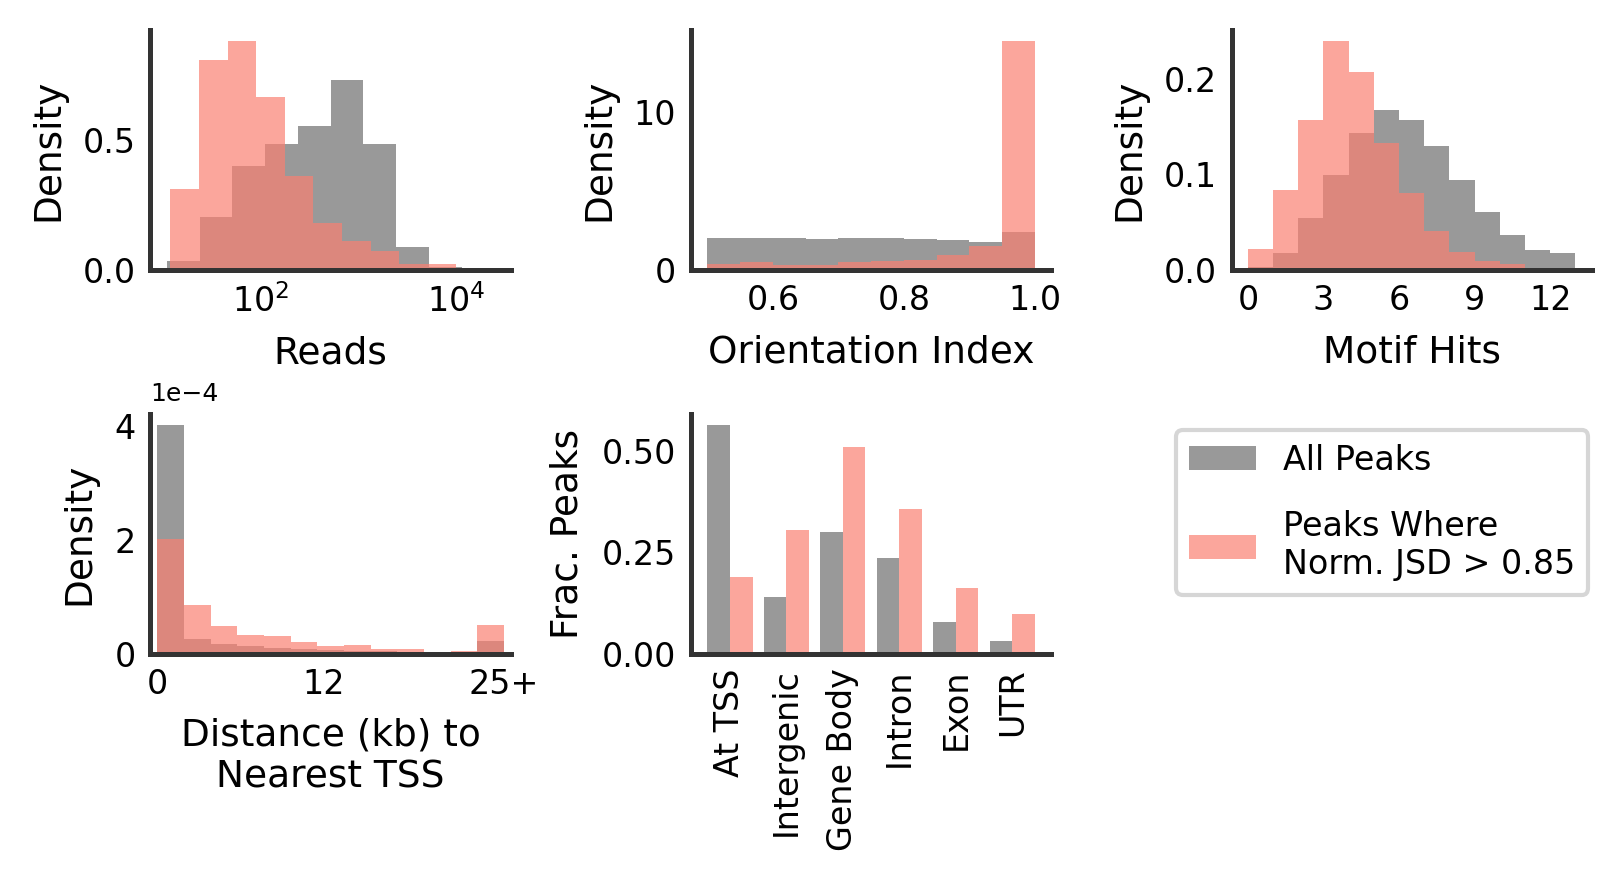

In [125]:
def make_ax_pretty(ax, linewidth=1.2, ax_color = "#333333", ticklabelsize=8):
    ax.spines[["left", "bottom"]].set_linewidth(linewidth)
    ax.spines[["left", "bottom"]].set_color(ax_color)
    ax.spines[["top", "right"]].set_visible(False)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')
    
    ax.tick_params(length=0, labelsize=ticklabelsize)
    

def make_plots_for_outliers(outlier_indexes, true_profs, true_counts,
                               peak_hit_counts, gene_region_annots, TSS_dists,
                           save_path=None):
    
    group_names = ["All Peaks", "Peaks Where\nNorm. JSD > 0.85"]
    
    regions_to_labels = {"promoters" : "At TSS",
                        "genes" : "Gene Body",
                        "genes_not_TSS" : "Gene Body",
                        "exons" : "Exon",
                        "exons_not_TSS" : "Exon",
                        "intergenic" : "Intergenic",
                        "intergenic_not_TSS" : "Intergenic",
                        "utrs" : "UTR",
                        "utrs_not_TSS" : "UTR",
                        "introns" : "Intron",
                        "introns_not_TSS" : "Intron"}
    regions_to_plot = ["promoters", "intergenic_not_TSS", "genes_not_TSS",
                       "introns_not_TSS", "exons_not_TSS", "utrs_not_TSS"]
    
    fig, axes = plt.subplots(2, 3, figsize=(6.2,2.7), dpi=300)
    plt.subplots_adjust(wspace=0.5, hspace=0.6)
    axes = axes.flatten()
    
    # Counts histogram
    
    log_all_true_counts = np.log10(true_counts.sum(axis=1) + 1)
    log_outlier_true_counts = np.log10(true_counts[outlier_indexes].sum(axis=1) + 1)
    
    axes[0].hist(log_all_true_counts, alpha=0.8, density=True, color="gray")
    axes[0].hist(log_outlier_true_counts, alpha=0.7, density=True, color="salmon")
    
    axes[0].set_xlabel("Reads", fontsize=9)
    axes[0].set_ylabel("Density", fontsize=9)
    
    xticks = [2,4]
    axes[0].set_xticks(xticks, [r'$10^{' + str(i) + r'}$' for i in xticks])
    
    # OI histogram
    
    ois = get_orientation_indexes(true_profs)
    
    axes[1].hist(ois,
                 alpha=0.8, density=True, color="gray")
    axes[1].hist(ois[outlier_indexes],
                 alpha=0.7, density=True, color="salmon")
    
    axes[1].set_xlabel("Orientation Index", fontsize=9)
    axes[1].set_ylabel("Density", fontsize=9)
    
    # Motif hits histogram
    
    motif_hits = peak_hit_counts.sum(axis=1)
    axes[2].hist(motif_hits,
             bins=range(14), alpha=0.8, density=True, color="gray")
    axes[2].hist(motif_hits[outlier_indexes],
             bins=range(14), alpha=0.7, density=True, color="salmon")
    
    axes[2].set_xlabel("Motif Hits", fontsize=9)
    axes[2].set_ylabel("Density", fontsize=9)
    
    axes[2].set_xticks(range(0,14,3))
    
    # TSS distances histogram

    stop_point = 25000
    num_bins = int(np.ceil(stop_point / 2000))
    axes[3].hist([min(d, stop_point) for d in TSS_dists if d is not None],
             density=True, bins=num_bins,
             alpha=0.8, color="gray")
    axes[3].hist([min(d, stop_point) for d in TSS_dists[outlier_indexes] if d is not None],
             density=True, bins=num_bins,
             alpha=0.7, color="salmon")

    axes[3].set_xlim(-500, stop_point + 500)
    axes[3].set_xlabel("Distance (kb) to\nNearest TSS", fontsize=9)
    axes[3].set_ylabel("Density", fontsize=9)
    axes[3].ticklabel_format(axis="y", style="scientific", scilimits=(0,0))
    axes[3].yaxis.offsetText.set_fontsize(6)
    
    middle_tick = int(stop_point / 2000) * 1000
    axes[3].set_xticks([0, middle_tick, stop_point],
                       ["0", middle_tick // 1000, str(stop_point // 1000) + "+"])
    
    # Gene annotation regions double bar plot

    fracs_overall = []
    fracs_in_region = []
    for region_name in regions_to_plot:
        region_bools = gene_region_annots[region_name]
        frac_overall = sum(region_bools) / len(region_bools)
        frac_in_region = sum(region_bools[outlier_indexes]) / len(region_bools[outlier_indexes])
        fracs_overall.append(frac_overall)
        fracs_in_region.append(frac_in_region)

    barplot_x_vals = np.arange(len(fracs_overall))
    bar_width = 0.4
    b1 = axes[4].bar(barplot_x_vals, fracs_overall,
                 width=bar_width, label=group_names[0], color="gray", alpha=0.8)
    # Same thing, but offset the x.
    b2 = axes[4].bar(barplot_x_vals + bar_width, fracs_in_region,
                 width=bar_width, label=group_names[1], color="salmon", alpha=0.7)

    # x axis ticks need to be offset to go under center of two bars
    axes[4].set_xticks(barplot_x_vals + bar_width / 2,
                       labels=[regions_to_labels[region_name] for region_name in regions_to_plot],
                       rotation=90, fontsize=6)
    axes[4].set_ylabel("Frac. Peaks", fontsize=9)
    axes[4].set_yticks([0, 0.25, 0.5])

    # will function as legend for all subplots
    axes[4].legend(bbox_to_anchor=(1.3,1), loc="upper left",
               frameon=True, labelspacing=1, fontsize=8)
    
    
    # cosmetics for each subplot
    for axis in axes:
        make_ax_pretty(axis)
    
    # disappear unused axis
    axes[-1].remove()
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    
    plt.show()
    
    
make_plots_for_outliers(low_JSD_site_indexes, true_profs, true_counts,
                           peak_hit_counts["profile"], gene_region_annots, TSS_dists,
                        save_path = figures_dir + "S1_outliers.png")

In [126]:
ois = get_orientation_indexes(true_profs)
print(np.sum(ois == 1), np.sum(ois[low_JSD_site_indexes] == 1))
print(np.sum(ois[low_JSD_site_indexes] == 1) / np.sum(ois == 1))

1312 714
0.5442073170731707


In [127]:
print(np.sum(ois[low_JSD_site_indexes] == 1), np.sum(low_JSD_site_indexes))
print(np.sum(ois[low_JSD_site_indexes] == 1) / np.sum(low_JSD_site_indexes))

714 1450
0.4924137931034483


In [129]:
np.sum(low_JSD_site_indexes) / true_profs.shape[0]

0.0474880461125303

In [121]:
def load_mappability_for_peaks(cell_type, model_type, data_type):
    config = MergedFilesConfig(cell_type, model_type, data_type)

    _, _, umap_masks = extract_peaks(config.genome_path,
                                     config.chrom_sizes,
                                     config.plus_bw_path,
                                     config.minus_bw_path,
                                     config.all_peak_path,
                                     mask_bw_path=config.mask_bw_path,
                                     in_window=in_window,
                                     out_window=out_window,
                                     max_jitter=0, verbose=True)
    return umap_masks
        
umap_masks = load_mappability_for_peaks(cell_type, model_type, data_type)

Loading genome sequence from /mnt/lab_data2/kcochran/procapnet/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:08<00:00,  2.99it/s]
Loading Peaks: 30534it [00:51, 593.23it/s]


== In Extract Peaks ==
Peak filepath: /mnt/lab_data2/kcochran/procapnet/data/procap/processed/K562/peaks.bed.gz
Sequence length (with jitter): 2114
Profile length (with jitter): 1000
Max jitter applied: 0
Num. Examples: 30534
Mask loaded? True


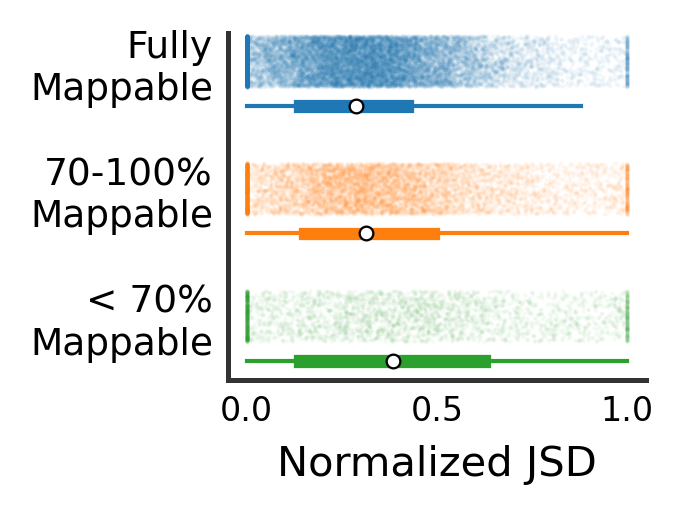

In [123]:
def plot_mappability_vs_performance(val_metrics, umap_masks, metric = "nll", save_path=None):
    umap_frac = umap_masks.mean(axis=(1,2))  # axis 1 is just 2 copies anyways

    umap_all_mappable = umap_frac == 1
    umap_mostly_mappable = (umap_frac < 1) * (umap_frac >= 0.7)
    umap_least_mappable = umap_frac < 0.7

    plt.figure(figsize=(1.8, 1.5), dpi=300)
    
    y_labels = []
    y_index = 0
    y_labels.append("Fully\nMappable")
    plot_scatter_and_boxplot(val_metrics[metric][umap_all_mappable], y_index,
                             color="tab:blue", dot_alpha=0.05)
    y_index += 1
    
    y_labels.append("70-100%\nMappable")
    plot_scatter_and_boxplot(val_metrics[metric][umap_mostly_mappable], y_index,
                             color="tab:orange", dot_alpha=0.05)
    y_index += 1
    
    y_labels.append("< 70%\nMappable")
    plot_scatter_and_boxplot(val_metrics[metric][umap_least_mappable], y_index,
                             color="tab:green", dot_alpha=0.05)
    y_index += 1

    plt.xlabel(norm_metric_names_fancy[metric])
        
    ax = plt.gca()
    ax.spines[["left", "bottom"]].set_linewidth(1.2)
    ax.spines[["left", "bottom"]].set_color("#333333")
    ax.spines[["top", "right"]].set_visible(False)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none')

    ax.tick_params(length=0)
    plt.xticks(fontsize=8)

    plt.yticks(range(len(y_labels)), y_labels, fontsize = 9)
    plt.ylim(plt.gca().get_ylim()[1], plt.gca().get_ylim()[0] - 0.1)
    
    if save_path is not None:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    
    plt.show()



#for metric_name in ["nll", "jsd", "profile_pearson"]:
for metric_name in ["jsd"]:
    plot_mappability_vs_performance(norm_val_metrics, umap_masks, metric=metric_name,
                                   save_path = figures_dir + "S1_mappability_" + metric_name + ".png")